# Ordinal Regression of Outcomes Categorical variable

This scenario includes another response variable: time in offensive/neutral/headon/defensive state

In [120]:
%load_ext autoreload
%autoreload 2

import os
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import torch

import gpytorch
import matplotlib.pyplot as plt
import seaborn as sns
import pyro
import pyro.distributions as dist
from pyro.infer import Predictive
from gpytorch.kernels import ScaleKernel, RBFKernel, PeriodicKernel, \
    LinearKernel, ProductKernel, AdditiveKernel, MaternKernel, SpectralMixtureKernel, \
        PiecewisePolynomialKernel, PolynomialKernel, RQKernel, RFFKernel
from gpytorch.priors import GammaPrior, HorseshoePrior

import tqdm
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.insert(0,"..")

import itertools
import collections
from adjustText import adjust_text
import arviz as az
import xarray as xr

# from modules.HetMOGP import HetMOGP
from modules.additive_hmogp import HetMOGP
from modules.prior import UniformPrior, BetaPrior
from modules.metrics import mean_sum_composition_errors, scotts_pi
from modules.stats_utils import compute_nlpd, compute_log_likelihood

In [138]:
# Cat / Dog
# Cat, Cat, Dog
# True: [1, 1, 0]
bern = dist.Bernoulli(torch.tensor([.9, .7, 1.]))
test_data = torch.tensor([1., 1., 0.])
print(-1*bern.log_prob(test_data).numpy().round(3))
nlpd = np.round(-bern.log_prob(test_data).sum().item(), 3)
print("NLPD:", np.round(-bern.log_prob(test_data).sum().item(), 3))
print("pc change:", np.round((nlpd/1.155-1)*100, 3), "%")

[ 0.105  0.357 15.942]
NLPD: 16.404
pc change: 1320.26 %


In [139]:
# Cat / Dog
# Cat, Cat, Dog
# True: [1, 1, 0]
bern = dist.Bernoulli(torch.tensor([.9, .7, .99]))
test_data = torch.tensor([1., 1., 0.])
print(-1*bern.log_prob(test_data).numpy().round(3))
nlpd = np.round(-bern.log_prob(test_data).sum().item(), 3)
print("NLPD:", np.round(-bern.log_prob(test_data).sum().item(), 3))
print("pc change:", np.round((nlpd/1.155-1)*100, 3), "%")

[0.105 0.357 4.605]
NLPD: 5.067
pc change: 338.701 %


In [140]:
# Cat / Dog
# Cat, Cat, Dog
# True: [1, 1, 0]
bern = dist.Bernoulli(torch.tensor([.9, .7, .9]))
test_data = torch.tensor([1., 1., 0.])
print(-1*bern.log_prob(test_data).numpy().round(2))
nlpd = np.round(-bern.log_prob(test_data).sum().item(), 3)
print("NLPD:", np.round(-bern.log_prob(test_data).sum().item(), 3))
print("pc change:", np.round((nlpd/1.155-1)*100, 3), "%")

[0.11 0.36 2.3 ]
NLPD: 2.765
pc change: 139.394 %


In [141]:
# Cat / Dog
# Cat, Cat, Dog
# True: [1, 1, 0]
bern = dist.Bernoulli(torch.tensor([.9, .7, .8]))
test_data = torch.tensor([1., 1., 0.])
print(-1*bern.log_prob(test_data).numpy().round(3))
nlpd = np.round(-bern.log_prob(test_data).sum().item(), 3)
print("NLPD:", np.round(-bern.log_prob(test_data).sum().item(), 3))
print("pc change:", np.round((nlpd/1.155-1)*100, 3), "%")

[0.105 0.357 1.609]
NLPD: 2.071
pc change: 79.307 %


In [145]:
# Cat / Dog
# Cat, Cat, Dog
# True: [1, 1, 0]
bern = dist.Bernoulli(torch.tensor([.9, .7, .5]))
test_data = torch.tensor([1., 1., 0.])
print(-1*bern.log_prob(test_data).numpy().round(3))
nlpd = np.round(-bern.log_prob(test_data).sum().item(), 3)
print("NLPD:", np.round(-bern.log_prob(test_data).sum().item(), 3))
print("pc change:", np.round((nlpd/1.155-1)*100, 3), "%")

[0.105 0.357 0.693]
NLPD: 1.155
pc change: 0.0 %


In [151]:
# Cat / Dog
# Cat, Cat, Dog
# True: [1, 1, 0]
bern = dist.Bernoulli(torch.tensor([.9, .7, .1]))
test_data = torch.tensor([1., 1., 0.])
print(-1*bern.log_prob(test_data).numpy().round(3))
nlpd = np.round(-bern.log_prob(test_data).sum().item(), 3)
print("NLPD:", np.round(-bern.log_prob(test_data).sum().item(), 3))
print("pc change:", np.round((nlpd/1.155-1)*100, 3), "%")

[0.105 0.357 0.105]
NLPD: 0.567
pc change: -50.909 %


In [152]:
# Cat / Dog
# Cat, Cat, Dog
# True: [1, 1, 0]
bern = dist.Bernoulli(torch.tensor([.9, .7, .01]))
test_data = torch.tensor([1., 1., 0.])
print(-1*bern.log_prob(test_data).numpy().round(3))
nlpd = np.round(-bern.log_prob(test_data).sum().item(), 3)
print("NLPD:", np.round(-bern.log_prob(test_data).sum().item(), 3))
print("pc change:", np.round((nlpd/1.155-1)*100, 3), "%")

[0.105 0.357 0.01 ]
NLPD: 0.472
pc change: -59.134 %


In [153]:
# Cat / Dog
# Cat, Cat, Dog
# True: [1, 1, 0]
bern = dist.Bernoulli(torch.tensor([.9, .7, 0.]))
test_data = torch.tensor([1., 1., 0.])
print(-1*bern.log_prob(test_data).numpy().round(3))
nlpd = np.round(-bern.log_prob(test_data).sum().item(), 3)
print("NLPD:", np.round(-bern.log_prob(test_data).sum().item(), 3))
print("pc change:", np.round((nlpd/1.155-1)*100, 3), "%")

[0.105 0.357 0.   ]
NLPD: 0.462
pc change: -60.0 %


In [154]:
# Cat / Dog
# Cat, Cat, Dog
# True: [1, 1, 0]
bern = dist.Bernoulli(torch.tensor([.4, .45, .6]))
test_data = torch.tensor([1., 1., 0.])
print(-1*bern.log_prob(test_data).numpy().round(3))
nlpd = np.round(-bern.log_prob(test_data).sum().item(), 3)
print("NLPD:", np.round(-bern.log_prob(test_data).sum().item(), 3))
print("pc change:", np.round((nlpd/1.155-1)*100, 3), "%")

[0.916 0.799 0.916]
NLPD: 2.631
pc change: 127.792 %


In [145]:
a_last = 0.2
b_last = 0.15

a = np.array([0.5, 0.3, a_last])
b = np.array([0.25, 0.6, b_last])

print("a sum:", a.sum())
print("b sum:", b.sum())

a_sub = (a[0:2] / a[0:2].sum()).round(3)
b_sub = (b[0:2] / b[0:2].sum()).round(3)

print("a_sub:", a_sub)
print("b_sub:", b_sub)

print("a_sub sum:", a_sub.sum())
print("b_sub sum:", b_sub.sum())

print("a,b Euclidean distance:", np.linalg.norm(a - b).round(3))
print("a_sub,b_sub Euclidean distance:", np.linalg.norm(a_sub - b_sub).round(3))

a sum: 1.0
b sum: 1.0
a_sub: [0.625 0.375]
b_sub: [0.294 0.706]
a_sub sum: 1.0
b_sub sum: 1.0
a,b Euclidean distance: 0.394
a_sub,b_sub Euclidean distance: 0.468


In [136]:
a[0:2] / a[0:2].sum()

array([0.68421053, 0.31578947])

In [131]:
a_norm = np.linalg.norm(a)
a_norm*a_last + a[0]

0.6858817502360184

In [127]:
a[0:2] * np.linalg.norm(a[0:2])

array([0.46532918, 0.21476732])

In [122]:
print("a_sub,b_sub norm:", np.linalg.norm(np.array([.684, .316]) - np.array([.222, .778])).round(3))

a_sub,b_sub norm: 0.653


In [16]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, neg_elbo):
        if neg_elbo < self.min_validation_loss:
            self.min_validation_loss = neg_elbo
            self.counter = 0
        elif neg_elbo > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

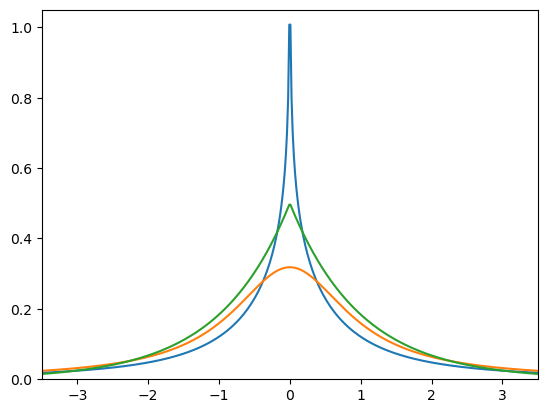

In [17]:
theta = np.linspace(-8, 8, 1000)
hs = HorseshoePrior(1)
cauchy = dist.Cauchy(0,1)
laplace = dist.Laplace(0,1)

hs_pdf = hs.log_prob(theta).exp()
cauchy_pdf = cauchy.log_prob(torch.tensor(theta)).exp()
laplace_pdf = laplace.log_prob(torch.tensor(theta)).exp()

sns.lineplot(x=theta, y=hs_pdf)
sns.lineplot(x=theta, y=cauchy_pdf)
sns.lineplot(x=theta, y=laplace_pdf)
plt.ylim([0, 1.05])
plt.xlim([-3.5,3.5]);

(0.0, 0.035)

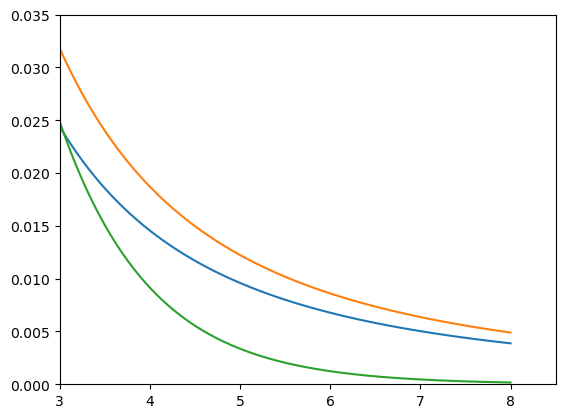

In [18]:
# theta = np.linspace(-8, 8, 1000)
sns.lineplot(x=theta, y=hs_pdf)
sns.lineplot(x=theta, y=cauchy_pdf)
sns.lineplot(x=theta, y=laplace_pdf)
plt.xlim([3, 8.5]);
plt.ylim([0,0.035])

<AxesSubplot: >

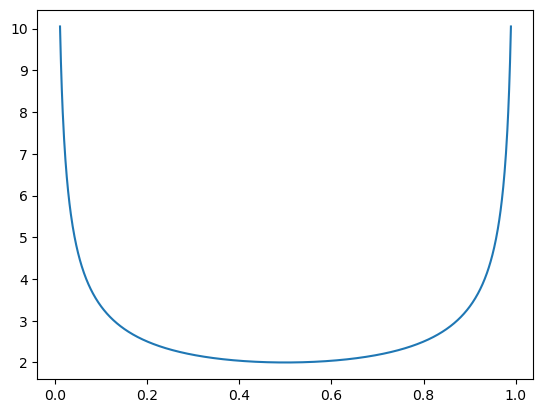

In [19]:
def local_shrinkage_lam(lam):
    pdf = (1 + lam**2)**(-1)
    return pdf

def local_shrinkage_kappa(kappa):
    pdf = kappa**(-1/2) * (1 - kappa)**(-1/2)
    return pdf


kappa = np.linspace(1e-2,1-1e-2,1000)
kappa_pdf = local_shrinkage_kappa(kappa)

sns.lineplot(x=kappa,y=kappa_pdf)

Data transform and EDA

In [20]:
df = pd.read_csv("../ace0/msl_evasion-005/msl_evasion-case-5.csv")

<AxesSubplot: ylabel='Density'>

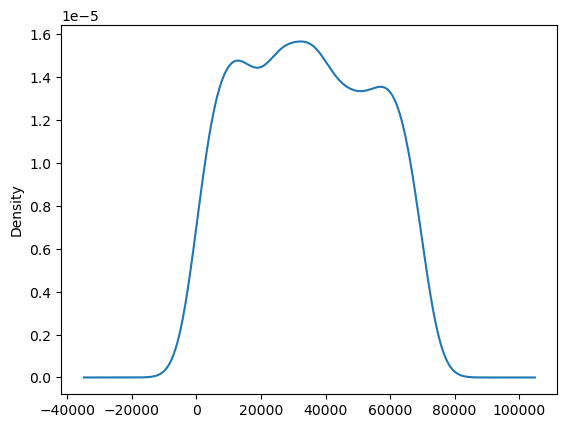

In [21]:
df.cobra_briefed_evasion_range.plot(kind="density")

In [22]:
df[df.viper_time_in_UNKNOWN > .2]

,run_number,total_run_time,viper_initial_contact_range,viper_initial_contact_ata,viper_initial_contact_aa,viper_briefed_behavior,viper_briefed_launch_range,viper_briefed_evasion_range,viper_alive,cobra_initial_contact_range,...,viper_time_in_UNKNOWN,cobra_time_in_UNKNOWN,viper_time_in_NEUTRAL,cobra_time_in_NEUTRAL,viper_time_in_DEFENSIVE,cobra_time_in_DEFENSIVE,viper_time_in_HEADON,cobra_time_in_HEADON,viper_time_in_OFFENSIVE,cobra_time_in_OFFENSIVE
160,161,300.0,60000.0,0.0,180.0,BehaviorType.ATTACK,69828.235191,29932.550171,1,60000.0,...,236.2,0.2,0.0,0.0,0.0,0.0,63.9,63.8,0.0,0.0
433,434,300.0,60000.0,0.0,180.0,BehaviorType.ATTACK,55051.960030,67417.715604,1,60000.0,...,233.4,0.2,0.0,0.0,0.0,0.0,66.7,66.6,0.0,0.0
449,450,300.0,60000.0,0.0,180.0,BehaviorType.ATTACK,54739.341056,63397.486667,1,60000.0,...,233.1,0.2,0.0,0.0,0.0,0.0,67.0,66.9,0.0,0.0
495,496,300.0,60000.0,0.0,180.0,BehaviorType.ATTACK,69454.678105,67274.636514,1,60000.0,...,237.1,0.2,0.0,0.0,0.0,0.0,63.0,62.9,0.0,0.0
538,539,300.0,60000.0,0.0,180.0,BehaviorType.ATTACK,62924.333499,59715.171341,1,60000.0,...,237.1,0.2,0.0,0.0,0.0,0.0,63.0,62.9,0.0,0.0
752,753,300.0,60000.0,0.0,180.0,BehaviorType.ATTACK,60803.054068,29584.407854,1,60000.0,...,237.1,0.2,0.0,0.0,0.0,0.0,63.0,62.9,0.0,0.0
807,808,300.0,60000.0,0.0,180.0,BehaviorType.ATTACK,48735.103109,51597.626266,1,60000.0,...,228.4,0.2,0.0,0.0,0.0,0.0,71.7,71.6,0.0,0.0
913,914,300.0,60000.0,0.0,180.0,BehaviorType.ATTACK,57141.608859,44514.159113,1,60000.0,...,235.0,0.2,0.0,0.0,0.0,0.0,65.1,65.0,0.0,0.0
915,916,300.0,60000.0,0.0,180.0,BehaviorType.ATTACK,67826.202465,65685.584491,1,60000.0,...,237.1,0.2,0.0,0.0,0.0,0.0,63.0,62.9,0.0,0.0


In [23]:
# q = .7
# viper_evansion_quantile = df.viper_briefed_evasion_range.quantile(.77)
# cobra_evansion_quantile = df.cobra_briefed_evasion_range.quantile(.77)

# idx = (df.viper_briefed_evasion_range < viper_evansion_quantile) & (df.cobra_briefed_evasion_range < cobra_evansion_quantile)

# df = df[idx]
# df.reset_index(drop=True, inplace=True)

In [24]:
idx_high_unknown = df[(df.viper_time_in_UNKNOWN > 0.2) | (df.cobra_time_in_UNKNOWN > 0.2)].index
print("highest time in UNKNOWN: ", df.iloc[idx_high_unknown].total_run_time.max())

highest time in UNKNOWN:  300.0


<AxesSubplot: ylabel='Density'>

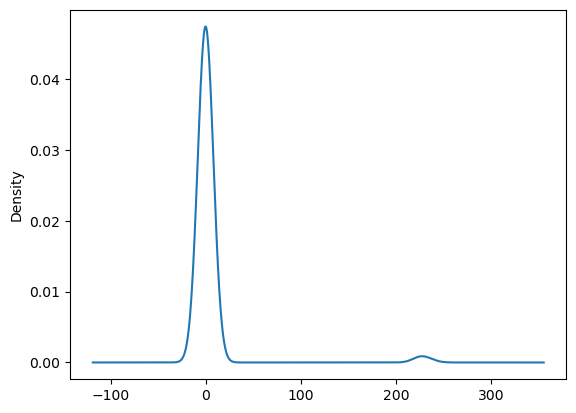

In [25]:
df_timein = df.iloc[:,df.columns.str.contains("viper_time_in") | df.columns.str.contains("total_run")]
df_timein["viper_total_run_time"] = df_timein.iloc[:,1:].sum(axis=1)
(df_timein.total_run_time - df_timein.viper_total_run_time).plot(kind="density")

In [26]:
subset_idx = list(set(df.index) - set(idx_high_unknown))
df = df.iloc[subset_idx]
df = df.reset_index(drop=True)

In [27]:
df.viper_time_in_HEADON = df.viper_time_in_HEADON + df.viper_time_in_UNKNOWN
df.cobra_time_in_HEADON = df.cobra_time_in_HEADON + df.cobra_time_in_UNKNOWN

In [28]:
unknown_col = df.iloc[:,df.columns.str.contains("time_in_UNKNOWN")].columns
df = df.drop(unknown_col, axis=1)

In [29]:
# mutual_kills = list(df[df.outcome=="MUTUAL_KILL"].index)
# df_mutual_kills = df.copy()
# df_mutual_kills = df.iloc[mutual_kills]

# df = df[df.outcome!="MUTUAL_KILL"].sample(n=300-len(mutual_kills), random_state=28).sort_index(0)
# df = pd.concat([df_mutual_kills, df])
# df.reset_index(drop=True, inplace=True)
# df.sort_index(0, inplace=True)

In [30]:
# viper_timein_col = [col for col in df.columns if "total_run" in col or "viper_time_in" in col]
# cobra_timein_col = [col for col in df.columns if "total_run" in col or "cobra_time_in" in col]

viper_timein_col = [col for col in df.columns if "viper_time_in" in col]
cobra_timein_col = [col for col in df.columns if "cobra_time_in" in col]

df_viper_portion = df[viper_timein_col].apply(lambda x: x / df.total_run_time)
df_cobra_portion = df[cobra_timein_col].apply(lambda x: x / df.total_run_time)

In [31]:
viper_portion_cols = [
    'viper_p_NEUTRAL', 
    'viper_p_DEFENSIVE',
    'viper_p_HEADON', 
    'viper_p_OFFENSIVE'
]

cobra_portion_cols = [
    'cobra_p_NEUTRAL', 
    'cobra_p_DEFENSIVE',
    'cobra_p_HEADON', 
    'cobra_p_OFFENSIVE'
]

df_viper_portion.columns = viper_portion_cols
df_cobra_portion.columns = cobra_portion_cols

In [32]:
df_viper_portion.max(), df_cobra_portion.max()

(viper_p_NEUTRAL      0.789386
 viper_p_DEFENSIVE    0.805634
 viper_p_HEADON       1.001585
 viper_p_OFFENSIVE    0.801329
 dtype: float64,
 cobra_p_NEUTRAL      0.789386
 cobra_p_DEFENSIVE    0.801329
 cobra_p_HEADON       1.001585
 cobra_p_OFFENSIVE    0.805634
 dtype: float64)

In [33]:
df_viper_portion.viper_p_HEADON = df_viper_portion.viper_p_HEADON.apply(lambda x: min(x, 1.0))
df_cobra_portion.cobra_p_HEADON = df_cobra_portion.cobra_p_HEADON.apply(lambda x: min(x, 1.0))

In [34]:
df = pd.concat([df, df_viper_portion, df_cobra_portion], axis=1)
df = df.reset_index(drop=True)

In [35]:
df.outcome.value_counts()

BOTH_SURVIVED    605
COBRA_WIN        183
VIPER_WIN        182
MUTUAL_KILL       11
Name: outcome, dtype: int64

In [36]:
# outcome_map = {
#     "VIPER_WIN": 2,
#     "BOTH_SURVIVED": 1,
#     "COBRA_WIN": 0,
# }
# df = df[df.outcome != "MUTUAL_KILL"]
# df.outcome = df.outcome.map(outcome_map)

outcome_map = {
    "VIPER_WIN": 3,
    "BOTH_SURVIVED": 2,
    "MUTUAL_KILL": 1,
    "COBRA_WIN": 0,
}
df.outcome = df.outcome.map(outcome_map)

df.viper_launched.replace({True: 1, False: 0}, inplace=True)
df.cobra_launched.replace({True: 1, False: 0}, inplace=True)

log_standardise = lambda x: (np.log(x) - np.mean(np.log(x))) / np.std(np.log(x))
log_norm = lambda x: (np.log(x) - np.min(np.log(x))) / (np.max(np.log(x)) - np.min(np.log(x)))
norm = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x))

def norm_custom(x, minval, maxval):
    x = (x - minval) / (maxval - minval)
    return x

# log normalise data
df["lognorm_viper_launch_range"] = df.viper_launch_range.pipe(log_norm)
df["lognorm_viper_briefed_launch_range"] = df.viper_briefed_launch_range.pipe(log_norm)
df["lognorm_viper_briefed_evasion_range"] = df.viper_briefed_evasion_range.pipe(log_norm)
df["lognorm_cobra_launch_range"] = df.cobra_launch_range.pipe(log_norm)
df["lognorm_cobra_briefed_launch_range"] = df.cobra_briefed_launch_range.pipe(log_norm)
df["lognorm_cobra_briefed_evasion_range"] = df.cobra_briefed_evasion_range.pipe(log_norm)

# normalise data
df["norm_viper_launch_range"] = df.viper_launch_range.pipe(norm)
df["norm_viper_briefed_launch_range"] = df.viper_briefed_launch_range.pipe(norm)
df["norm_viper_briefed_evasion_range"] = df.viper_briefed_evasion_range.pipe(norm)
df["norm_cobra_launch_range"] = df.cobra_launch_range.pipe(norm)
df["norm_cobra_briefed_launch_range"] = df.cobra_briefed_launch_range.pipe(norm)
df["norm_cobra_briefed_evasion_range"] = df.cobra_briefed_evasion_range.pipe(norm)

# compute min, max vals among both cobra and viper
evasion_minval = pd.concat([df.cobra_briefed_evasion_range, df.viper_briefed_evasion_range]).min()
evasion_maxval = pd.concat([df.cobra_briefed_evasion_range, df.viper_briefed_evasion_range]).max()
launch_minval = pd.concat([df.cobra_launch_range, df.viper_launch_range]).min()
launch_maxval = pd.concat([df.cobra_launch_range, df.viper_launch_range]).max()
briefed_launch_minval = pd.concat([df.cobra_briefed_launch_range, df.viper_briefed_launch_range]).min()
briefed_launch_maxval = pd.concat([df.cobra_briefed_launch_range, df.viper_briefed_launch_range]).max()

# difference between evasion and launch. normalised
df["briefed_evasion_range_diff"] = df.viper_briefed_evasion_range.apply(lambda x: norm_custom(x, evasion_minval, evasion_maxval)) - df.cobra_briefed_evasion_range.apply(lambda x: norm_custom(x, evasion_minval, evasion_maxval))
df["launch_range_diff"] = df.viper_launch_range.apply(lambda x: norm_custom(x, launch_minval, launch_maxval)) - df.cobra_launch_range.apply(lambda x: norm_custom(x, launch_minval, launch_maxval))
df["briefed_launch_range_diff"] = df.viper_briefed_launch_range.apply(lambda x: norm_custom(x, briefed_launch_minval, briefed_launch_maxval)) - df.cobra_briefed_launch_range.apply(lambda x: norm_custom(x, briefed_launch_minval, briefed_launch_maxval))

# difference between time launched
df["time_at_launch_diff"] = df.viper_time_at_launch - df.cobra_time_at_launch

# difference between launch range and evasion range
df["viper_launch_cobra_evade_diff"] = df.viper_briefed_launch_range - df.cobra_briefed_evasion_range
df["viper_evade_cobra_launch_diff"] = df.viper_briefed_evasion_range - df.cobra_briefed_launch_range

viper_launch_range = -1 when viper does not launch. normally happens when viper evades without launching


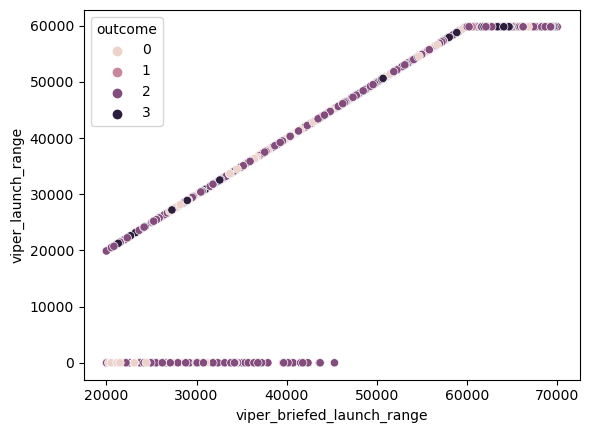

In [37]:
# when viper launches first, viper typically has a longer briefed launch range
sns.scatterplot(x=df.viper_briefed_launch_range, y=df.viper_launch_range, hue=df.outcome)
print("viper_launch_range = -1 when viper does not launch. normally happens when viper evades without launching")

<AxesSubplot: xlabel='time_at_launch_diff', ylabel='Density'>

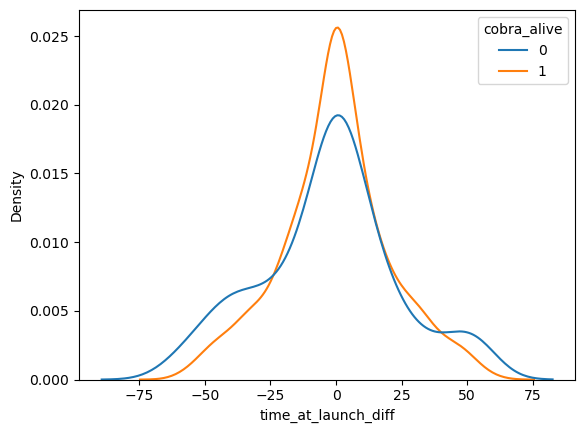

In [38]:
sns.kdeplot(x=df.time_at_launch_diff, hue=df.cobra_alive, common_norm=False)

<AxesSubplot: xlabel='briefed_evasion_range_diff', ylabel='briefed_launch_range_diff'>

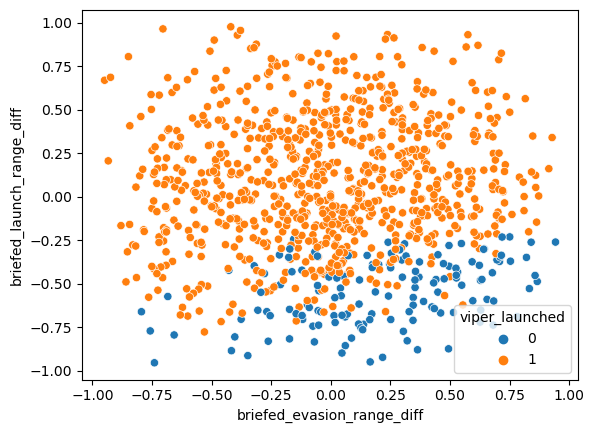

In [39]:
# longer launch range and shorter evasion range more advantageous for viper?
sns.scatterplot(x=df.briefed_evasion_range_diff, y=df.briefed_launch_range_diff, hue=df.viper_launched)

<AxesSubplot: xlabel='briefed_evasion_range_diff', ylabel='briefed_launch_range_diff'>

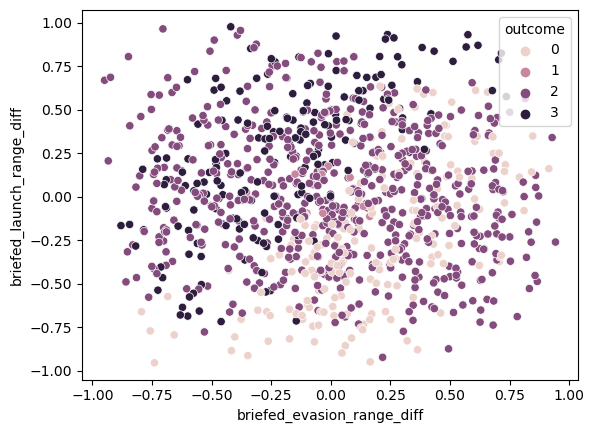

In [40]:
# longer launch range and shorter evasion range more advantageous for viper?
sns.scatterplot(x=df.briefed_evasion_range_diff, y=df.briefed_launch_range_diff, hue=df.outcome)

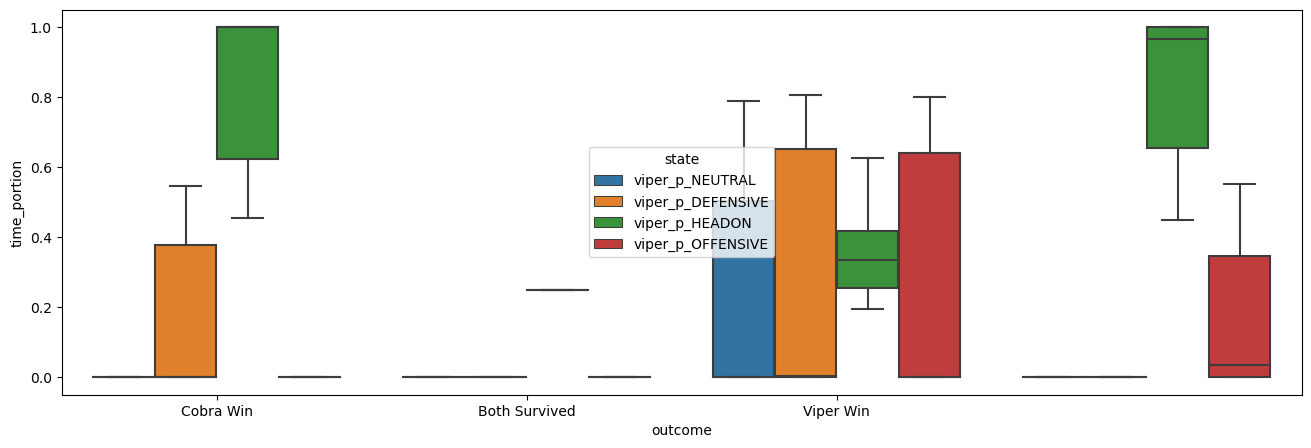

In [41]:
plt.figure(figsize=(16,5))
df_box = df.melt(id_vars=["run_number", "outcome"], value_vars=viper_portion_cols, value_name="time_portion", var_name="state")
sns.boxplot(data=df_box, x="outcome", y="time_portion", hue="state")
# plt.xticks([0, 1, 2, 3], labels=["Cobra Win", "Mutual Kill", "Both Survived", "Viper Win"]);
plt.xticks([0, 1, 2], labels=["Cobra Win", "Both Survived", "Viper Win"]);

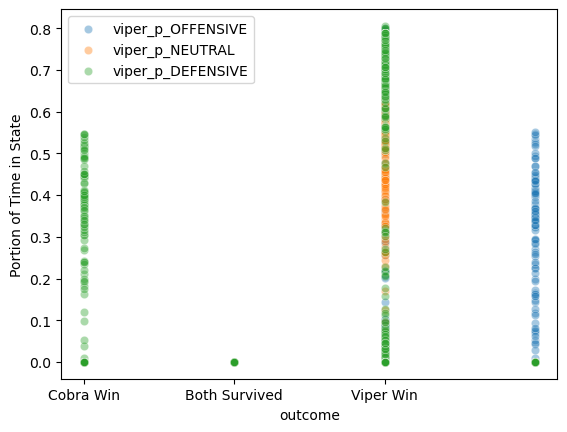

In [42]:
# longer launch range and shorter evasion range more advantageous for viper?
sns.scatterplot(y=df.viper_p_OFFENSIVE , x=df.outcome, alpha=.4, label="viper_p_OFFENSIVE")
sns.scatterplot(y=df.viper_p_NEUTRAL , x=df.outcome, alpha=.4, label="viper_p_NEUTRAL")
sns.scatterplot(y=df.viper_p_DEFENSIVE , x=df.outcome, alpha=.4, label="viper_p_DEFENSIVE")
plt.ylabel("Portion of Time in State")
# plt.xticks([0, 1, 2, 3], labels=["Cobra Win", "Mutual Kill", "Both Survived", "Viper Win"]);
plt.xticks([0, 1, 2], labels=["Cobra Win", "Both Survived", "Viper Win"]);

<AxesSubplot: xlabel='viper_time_at_launch', ylabel='Density'>

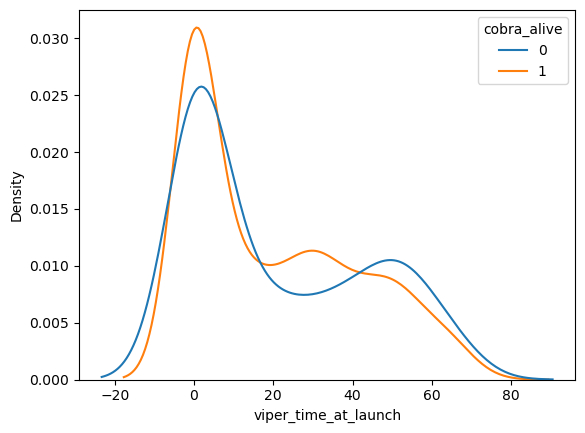

In [43]:
sns.kdeplot(x=df.viper_time_at_launch, hue=df.cobra_alive, common_norm=False)

<AxesSubplot: xlabel='cobra_time_at_launch', ylabel='Density'>

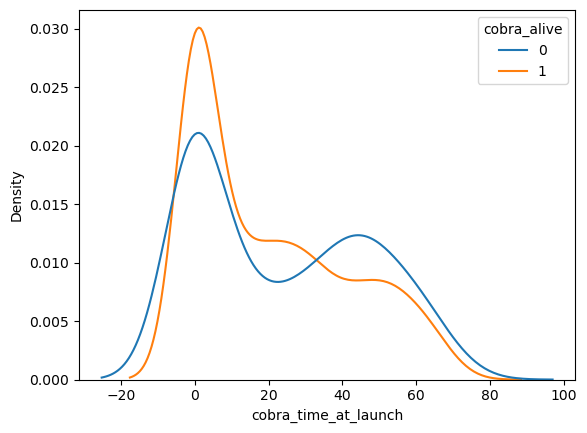

In [44]:
sns.kdeplot(x=df.cobra_time_at_launch, hue=df.cobra_alive, common_norm=False)

<AxesSubplot: xlabel='lognorm_viper_launch_range', ylabel='Density'>

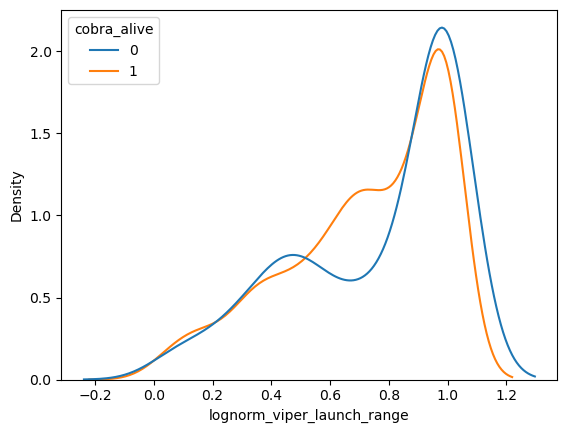

In [45]:
sns.kdeplot(x=df.lognorm_viper_launch_range, hue=df.cobra_alive, common_norm=False)

<AxesSubplot: xlabel='lognorm_cobra_launch_range', ylabel='Density'>

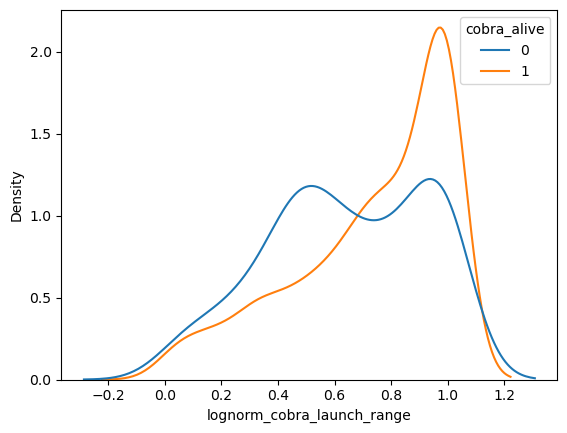

In [46]:
sns.kdeplot(x=df.lognorm_cobra_launch_range, hue=df.cobra_alive, common_norm=False)

<AxesSubplot: xlabel='lognorm_viper_briefed_evasion_range', ylabel='Density'>

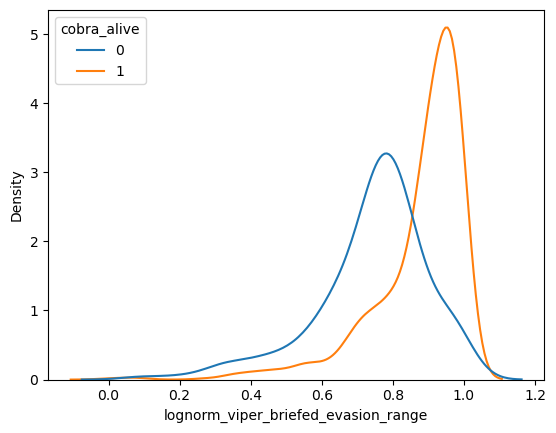

In [47]:
sns.kdeplot(x=df.lognorm_viper_briefed_evasion_range, hue=df.cobra_alive, common_norm=False)

<AxesSubplot: xlabel='lognorm_cobra_briefed_evasion_range', ylabel='Density'>

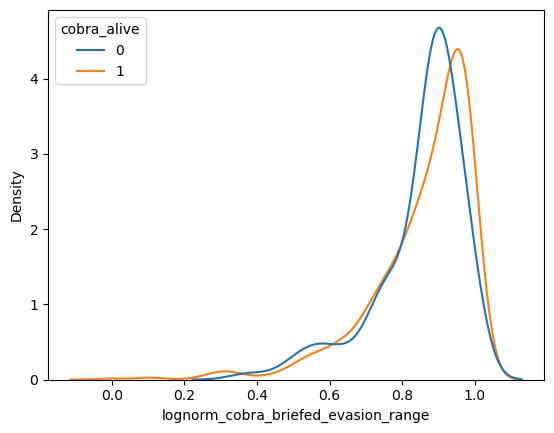

In [48]:
sns.kdeplot(x=df.lognorm_cobra_briefed_evasion_range, hue=df.cobra_alive, common_norm=False)

Setup train, test dataset

In [49]:
input_set1 = [
    "lognorm_viper_launch_range",
    "lognorm_viper_briefed_evasion_range",
    "lognorm_cobra_launch_range",
    "lognorm_cobra_briefed_evasion_range",
]

input_set2 = [
    "norm_viper_launch_range",
    "norm_viper_briefed_evasion_range",
    "norm_cobra_launch_range",
    "norm_cobra_briefed_evasion_range",
]

input_set3 = [
    "launch_range_diff",
    "briefed_evasion_range_diff",
]

input_set4 = [
    "briefed_launch_range_diff",
    "briefed_evasion_range_diff",
]

input_set5 = [
    "lognorm_viper_briefed_launch_range",
    "lognorm_viper_briefed_evasion_range",
    "lognorm_cobra_briefed_launch_range",
    "lognorm_cobra_briefed_evasion_range",
]

input_set6 = [
    "viper_launched",
    "lognorm_viper_briefed_launch_range",
    "lognorm_viper_briefed_evasion_range",
    "cobra_launched",
    "lognorm_cobra_briefed_launch_range",
    "lognorm_cobra_briefed_evasion_range",
]

input_set7 = [
    "norm_viper_launch_range",
    "norm_viper_briefed_evasion_range",
    "norm_cobra_launch_range",
    "norm_cobra_briefed_evasion_range",
    "briefed_launch_range_diff",
    "briefed_evasion_range_diff",
]

input_set8 = [
    "norm_viper_briefed_launch_range",
    "norm_viper_briefed_evasion_range",
    "norm_cobra_briefed_launch_range",
    "norm_cobra_briefed_evasion_range",
]

response1 = ["outcome"]
response2 = ["outcome"] + viper_portion_cols
response3 = ["outcome"] + viper_portion_cols + cobra_portion_cols
response4 = ["outcome"] + viper_portion_cols + cobra_portion_cols + ["viper_launched"] + ["cobra_launched"]

In [50]:
eps = 1e-4
df_copy = df.copy()
df_copy[viper_portion_cols] = df_copy[viper_portion_cols].replace(0, eps)
df_copy[viper_portion_cols] = df_copy[viper_portion_cols].replace(1, 1 - eps)
df_copy[viper_portion_cols] = normalize(df_copy[viper_portion_cols], norm="l1", axis=1)

df_copy[cobra_portion_cols] = df_copy[cobra_portion_cols].replace(0, eps)
df_copy[cobra_portion_cols] = df_copy[cobra_portion_cols].replace(1, 1 - eps)
df_copy[cobra_portion_cols] = normalize(df_copy[cobra_portion_cols], norm="l1", axis=1)

In [51]:
# X = torch.tensor(df_copy[input_set5].values, dtype=torch.float)
X = torch.tensor(df_copy[input_set8].values, dtype=torch.float)
# Need to torch.float for y, since we have categorical and proportions
y = torch.tensor(df_copy[response4].values, dtype=torch.float)

# redo this so the min, max values are in the training set for each dim
# manual_seed = 99
# for i in range(10000):
train_idx, test_idx = torch.utils.data.random_split(X, [.6, .4], \
    generator=torch.Generator().manual_seed(80))
train_idx, test_idx = train_idx.indices, test_idx.indices

train_x = X[train_idx,:]
test_x = X[test_idx,:]
train_y = y[train_idx,:]
test_y = y[test_idx,:]
    
    # if bool((test_x.min(0)[0]==0).all()) and bool((test_x.max(0)[0]==1).all()):
    #     break

# if torch.cuda.is_available():
#     train_x, train_y, test_x, test_y = train_x.cuda(), train_y.cuda(), test_x.cuda(), test_y.cuda()

# Fit the model

In [169]:
path = "msl_evasion-005/msl_evasion-case-5_edited.csv"
df = pd.read_csv(path, index_col=0)

# X = torch.tensor(df_copy[input_set5].values, dtype=torch.float)
X = torch.tensor(df[input_set8].values, dtype=torch.float)
# Need to torch.float for y, since we have categorical and proportions
y = torch.tensor(df[response4].values, dtype=torch.float)

train_idx, test_idx = torch.utils.data.random_split(X, [.6, .4], \
    generator=torch.Generator().manual_seed(80))
train_idx, test_idx = train_idx.indices, test_idx.indices

train_x = X[train_idx,:]
test_x = X[test_idx,:]
train_y = y[train_idx,:]
test_y = y[test_idx,:]

In [170]:
# WARNING! CAREFUL NOT TO RUN THIS CELL
identifier_list = ["test_id", "kcid", "lmc_prior_code", "lengthscale_prior_code"]
pareto_k_label = ["k_count_good", "k_count_ok", "k_count_bad", "k_count_verybad"]

lengthscales_df = pd.DataFrame(columns= identifier_list + ["lengthscales"])
lmc_df = pd.DataFrame(columns= identifier_list + ["lmc_coeff"])
loo_df = pd.DataFrame(columns= identifier_list + ["test_data", "elpd_loo", "p_loo", "se", "warning", "n_data_points", "n_samples", "scale"] + pareto_k_label + [f"elpd_loo_y{i}" for i in range(5)])
loo_train_df = loo_df.copy()
nlpd_df = pd.DataFrame(columns= identifier_list + ["y0", "y1", "y2", "y3", "y4"])
agreement_df = pd.DataFrame(columns= identifier_list + ["weight", "y0", "y3", "y4"])
msce_df = pd.DataFrame(columns= identifier_list + ["y1", "y2"])
kernel_structure_df = pd.DataFrame(columns= identifier_list + ["kernel_structure", "n_kernels", "active_dims", "additive", "independent_outputs", "compute_time"])

In [171]:
# run in each new scenario
lengthscales_dict = collections.defaultdict(collections.defaultdict)
lmc_dict = collections.defaultdict(collections.defaultdict)
loo_dict = collections.defaultdict(collections.defaultdict)
loo_train_dict = collections.defaultdict(collections.defaultdict)
nlpd_dict = collections.defaultdict(collections.defaultdict)
agreement_dict = collections.defaultdict(collections.defaultdict)
msce_dict = collections.defaultdict(collections.defaultdict)
kernel_structure_dict = collections.defaultdict(collections.defaultdict)

model_stats_dictlist = [lengthscales_dict, lmc_dict, loo_dict, loo_train_dict, nlpd_dict,
                        agreement_dict, msce_dict, kernel_structure_dict,]

In [172]:
test_id = 330
kcid = 0 # kernel combination id
# 0: no prior
# 1: weakly sparse inducing
# 2: sparse inducing
lmc_prior_code = 2
lengthscale_prior_code = 1

for stats_dict in model_stats_dictlist:
    stats_dict["test_id"] = test_id
    stats_dict["kcid"] = kcid
    stats_dict["lmc_prior_code"] = lmc_prior_code
    stats_dict["lengthscale_prior_code"] = lengthscale_prior_code

In [174]:
input_dims = train_x.size(-1)
kernel_per_input = 6
active_dims = []
additive = True
independent_outputs = False

if additive:
    for i in range(input_dims):
        for j in range(1):
            for k in range(kernel_per_input):
                active_dims.append([i])
else:
    for j in range(1):
        for k in range(kernel_per_input):
            active_dims.append(list(range(0,input_dims)))

n_kernels = len(active_dims)
print("number of kernels =", n_kernels)

kernel_structure_dict["n_kernels"] = n_kernels
kernel_structure_dict["active_dims"] = active_dims
kernel_structure_dict["additive"] = additive
kernel_structure_dict["independent_outputs"] = independent_outputs

number of kernels = 24


In [175]:
if lmc_prior_code == 0:
        lmc_coefficients_prior = None
        # low = torch.tensor(-10, dtype=torch.float, device=train_x.device)
        # high = torch.tensor(10, dtype=torch.float, device=train_x.device)
        # lmc_coefficients_prior = UniformPrior(low, high)
elif lmc_prior_code == 1:
        lmc_coefficients_prior = gpytorch.priors.NormalPrior(0,1)
elif lmc_prior_code == 2:
        # lmc_coefficients_prior = HorseshoePrior(2.)
        # lmc_coefficients_prior = HorseshoePrior(1.)
        lmc_coefficients_prior = HorseshoePrior(.5)
        # lmc_coefficients_prior = HorseshoePrior(torch.tensor([.5]))
        # lmc_coefficients_prior = HorseshoePrior(torch.tensor([.25]).expand([n_kernels, 16]))

if lengthscale_prior_code == 0:
        lengthscale_prior = None
elif lengthscale_prior_code == 1:
        gamma_mean = 2.
        gamma_std = 2.
        alpha = gamma_mean**2 / np.sqrt(gamma_std)
        beta = gamma_mean / np.sqrt(gamma_std)
        lengthscale_prior = GammaPrior(alpha, beta)        

batch_shape=torch.Size([1])
# kernels = [
#         [ProductKernel(
#                 RBFKernel(lengthscale_prior=lengthscale_prior, 
#                           batch_shape=batch_shape), 
#                 LinearKernel(lengthscale_prior=lengthscale_prior, 
#                              batch_shape=batch_shape)),
#          MaternKernel(nu=3/2, 
#                       lengthscale_prior=lengthscale_prior, 
#                       batch_shape=batch_shape)] 
#         for _ in range(n_kernels // 2)]
if additive:
        ard_num_dims = None
else:
        ard_num_dims = input_dims        

# To try: PiecewisePolynomialKernel, PolynomialKernel, RQKernel, RFFKernel

# kernels = [
#         [RBFKernel(lengthscale_prior=lengthscale_prior, 
#                           batch_shape=batch_shape,
#                           ard_num_dims=ard_num_dims),
#          MaternKernel(nu=3/2, 
#                       lengthscale_prior=lengthscale_prior, 
#                       batch_shape=batch_shape,
#                       ard_num_dims=ard_num_dims)] 
#         for _ in range(n_kernels // 2)]



if not independent_outputs:
        
        kernels = [
        [
                # PiecewisePolynomialKernel(q=3,
                #         #   lengthscale_prior=lengthscale_prior, 
                #           batch_shape=batch_shape,
                #           ard_num_dims=ard_num_dims),
         RBFKernel(lengthscale_prior=lengthscale_prior, 
                          batch_shape=batch_shape,
                          ard_num_dims=ard_num_dims),
          RBFKernel(lengthscale_prior=lengthscale_prior, 
                          batch_shape=batch_shape,
                          ard_num_dims=ard_num_dims),
           RBFKernel(lengthscale_prior=lengthscale_prior, 
                          batch_shape=batch_shape,
                          ard_num_dims=ard_num_dims),
        #  ProductKernel(RBFKernel(lengthscale_prior=lengthscale_prior, 
        #                   batch_shape=batch_shape,
        #                   ard_num_dims=ard_num_dims),
        #                MaternKernel(nu=2.5,
        #                             lengthscale_prior=lengthscale_prior, 
        #                             batch_shape=batch_shape,
        #                             ard_num_dims=ard_num_dims)),
         ] 
        for _ in range(n_kernels // 3)]

        kernels = list(itertools.chain(*kernels))

        # Categorical
        # likelihoods = ["Categorical", "HetDirichlet", "HetDirichlet", "Bernoulli", "Bernoulli"]
        # model = HetMOGP(train_x, num_lpf=16, likelihoods=likelihoods, kernels=kernels, active_dims=active_dims, num_inducing=100, jitter_val = 1e-3, n_compositions=[4, 4], 
        #                 lmc_coefficients_prior=lmc_coefficients_prior,
        #                 independent_outputs=independent_outputs,
        #                 )
        
        # Ordinal
        likelihoods = ["OrderedLogistic", "HetDirichlet", "HetDirichlet", "Bernoulli", "Bernoulli"]
        model = HetMOGP(train_x, num_lpf=13, likelihoods=likelihoods, kernels=kernels, active_dims=active_dims, num_inducing=100, jitter_val = 1e-3, n_compositions=[4, 4], n_classes=4, 
                        lmc_coefficients_prior=lmc_coefficients_prior,
                        independent_outputs=independent_outputs,
                        )

else:     
        def get_kernel(batch_shape):
                batch_shape = torch.Size([batch_shape])
                # batch_shape = torch.Size([1])
                kernels = AdditiveKernel(ScaleKernel(PiecewisePolynomialKernel(q=3,
                                                                batch_shape=batch_shape,
                                                                ard_num_dims=ard_num_dims,
                                                                active_dims=0)),
                                                ScaleKernel(RBFKernel(lengthscale_prior=lengthscale_prior, 
                                                                batch_shape=batch_shape,
                                                                ard_num_dims=ard_num_dims,
                                                                active_dims=0)),
                                                # ProductKernel(RBFKernel(lengthscale_prior=lengthscale_prior, 
                                                #                         batch_shape=batch_shape,
                                                #                         ard_num_dims=ard_num_dims,
                                                #                         active_dims=0),
                                                #               MaternKernel(nu=2.5,
                                                #                            lengthscale_prior=lengthscale_prior, batch_shape=batch_shape,
                                                #                            ard_num_dims=ard_num_dims,
                                                #                            active_dims=0)),
                                                ScaleKernel(PiecewisePolynomialKernel(q=3,
                                                                batch_shape=batch_shape,
                                                                ard_num_dims=ard_num_dims,
                                                                active_dims=1)),
                                                ScaleKernel(RBFKernel(lengthscale_prior=lengthscale_prior, 
                                                                batch_shape=batch_shape,
                                                                ard_num_dims=ard_num_dims,
                                                                active_dims=1)),
                                                # ProductKernel(RBFKernel(lengthscale_prior=lengthscale_prior, 
                                                #                         batch_shape=batch_shape,
                                                #                         ard_num_dims=ard_num_dims,
                                                #                         active_dims=1),
                                                #               MaternKernel(nu=2.5,
                                                #                            lengthscale_prior=lengthscale_prior, batch_shape=batch_shape,
                                                #                            ard_num_dims=ard_num_dims,
                                                #                            active_dims=1)),
                                                ScaleKernel(PiecewisePolynomialKernel(q=3,
                                                                batch_shape=batch_shape,
                                                                ard_num_dims=ard_num_dims,
                                                                active_dims=2)),
                                                ScaleKernel(RBFKernel(lengthscale_prior=lengthscale_prior, 
                                                                batch_shape=batch_shape,
                                                                ard_num_dims=ard_num_dims,
                                                                active_dims=2)),
                                                # ProductKernel(RBFKernel(lengthscale_prior=lengthscale_prior, 
                                                #                         batch_shape=batch_shape,
                                                #                         ard_num_dims=ard_num_dims,
                                                #                         active_dims=2),
                                                #               MaternKernel(nu=2.5,
                                                #                            lengthscale_prior=lengthscale_prior, batch_shape=batch_shape,
                                                #                            ard_num_dims=ard_num_dims,
                                                #                            active_dims=2)),
                                                ScaleKernel(PiecewisePolynomialKernel(q=3,
                                                                batch_shape=batch_shape,
                                                                ard_num_dims=ard_num_dims,
                                                                active_dims=3)),
                                                ScaleKernel(RBFKernel(lengthscale_prior=lengthscale_prior, 
                                                                batch_shape=batch_shape,
                                                                ard_num_dims=ard_num_dims,
                                                                active_dims=3)),
                                                # ProductKernel(RBFKernel(lengthscale_prior=lengthscale_prior, 
                                                #                         batch_shape=batch_shape,
                                                #                         ard_num_dims=ard_num_dims,
                                                #                         active_dims=3),
                                                #               MaternKernel(nu=2.5,
                                                #                            lengthscale_prior=lengthscale_prior, batch_shape=batch_shape,
                                                #                            ard_num_dims=ard_num_dims,
                                                #                            active_dims=3)),
                                                )
                return kernels
        
        
        # y0
        kernels = get_kernel(4)
        model_y0 = HetMOGP(train_x, num_lpf=4, likelihoods=["Categorical"], kernels=kernels,
                           active_dims=None, num_inducing=100, jitter_val = 1e-3, n_compositions=4, lmc_coefficients_prior=lmc_coefficients_prior, independent_outputs=independent_outputs,
                           )
        
        # y1
        kernels = get_kernel(5)
        model_y1 = HetMOGP(train_x, num_lpf=5, likelihoods=["HetDirichlet"], kernels=kernels,
                           active_dims=None, num_inducing=100, jitter_val = 1e-3, n_compositions=4, lmc_coefficients_prior=lmc_coefficients_prior,
                           independent_outputs=independent_outputs,
                           )
        
        # y2
        kernels = get_kernel(5)
        model_y2 = HetMOGP(train_x, num_lpf=5, likelihoods=["HetDirichlet"], kernels=kernels,
                           active_dims=None, num_inducing=100, jitter_val = 1e-3, n_compositions=4, lmc_coefficients_prior=lmc_coefficients_prior,
                           independent_outputs=independent_outputs,
                           )
        
        # y3
        kernels = get_kernel(1)
        model_y3 = HetMOGP(train_x, num_lpf=1, likelihoods=["Bernoulli"], kernels=kernels,
                           active_dims=None, num_inducing=100, jitter_val = 1e-3, n_compositions=4, lmc_coefficients_prior=lmc_coefficients_prior,
                           independent_outputs=independent_outputs,
                           )
        
        # y4
        kernels = get_kernel(1)
        model_y4 = HetMOGP(train_x, num_lpf=1, likelihoods=["Bernoulli"], kernels=kernels,
                           active_dims=None, num_inducing=100, jitter_val = 1e-3, n_compositions=4, lmc_coefficients_prior=lmc_coefficients_prior,
                           independent_outputs=independent_outputs,
                           )
        
        model_list = [model_y0, model_y1, model_y2, model_y3, model_y4]
        # model_list = [model_y0]

# if torch.cuda.is_available():
#     model = model.cuda()

In [176]:
pyro.set_rng_seed(88)
pyro.clear_param_store()

num_iter = 2000
# num_iter = 1000 # for actual training
# num_iter = 700 # for testing if the code works
# num_iter = 50 # for testing if the code works
# num_particles = 5
num_particles = 10
# num_particles = 2
# num_particles = 1

# If getting Matrix not PSD error try:
# - decreasing gamma = 1e-3 / decreasing final_lr = 1e-3 or lower (for fast training, try final_lr = 1e-2)
# - decreasing num_iter
# - tightening the lengthscale prior or kernel parameters

lrd_num_iter = 700
initial_lr = 1e-1
final_lr = 1e-3
gamma = final_lr / initial_lr  # final learning rate will be gamma * initial_l|r
lrd = gamma ** (1 / lrd_num_iter) # learning rate decay

optimizer = pyro.optim.ClippedAdam({
    'lr': initial_lr, 
    'lrd': lrd,
    'clip_norm': .001, # best = .001
    'betas': (0.93, 0.99999)})

# optimizer = pyro.optim.AdagradRMSProp({
#     # 'rho': .2,
#     'eta': .2,
#     't': .5,
#     # 'lr': initial_lr, 
#     # 'lr_decay': lrd,
#     # 'betas': (0.98, 0.999),
#     # 'amsgrad': True,
# })


elbo = pyro.infer.Trace_ELBO(num_particles=num_particles, vectorize_particles=True, retain_graph=True)
svi = pyro.infer.SVI(model.model, model.guide, optimizer, elbo)

model.train()
start = datetime.now()
iterator = tqdm.notebook.tqdm(range(num_iter), desc="Epoch")
loss_array = np.zeros(num_iter)
if not independent_outputs:
    early_stopper = EarlyStopper(patience=50, min_delta=0)
    for i in iterator:
        model.zero_grad()
        loss = svi.step(x=train_x, y=train_y)
        loss_array[i] = loss
        iterator.set_postfix(loss=loss)
        if early_stopper.early_stop(loss) and i >= 100:
                break
else:
    dims = [[0], list(range(1,5)), list(range(5,9)), [9], [10]]
    loss_array = np.zeros((num_iter,5))
    for q, m in enumerate(model_list):
        pyro.clear_param_store()
        elbo = pyro.infer.Trace_ELBO(num_particles=num_particles, vectorize_particles=True, retain_graph=True)
        svi = pyro.infer.SVI(m.model, m.guide, optimizer, elbo)
        print("dim =", q)
        m.train()
        iterator = tqdm.notebook.tqdm(range(num_iter), desc="Epoch")
        for i in iterator:
            m.zero_grad()
            loss = svi.step(x=train_x, y=train_y[...,dims[q]])
            loss_array[i,q] = loss
            iterator.set_postfix(loss=loss)
compute_time = (datetime.now() - start).total_seconds()
# computing time = 2:22 for y_0, y_1, loss = -99.5 / dim=-1 GPU
# computing time = 1:27 for y_0, y_1, loss = -101 / dim=-1 CPU

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

In [455]:
# loss_array[-1].sum()
# -223.0983670130372

In [456]:
# loss: 4.04
# nlpd = 0.992391

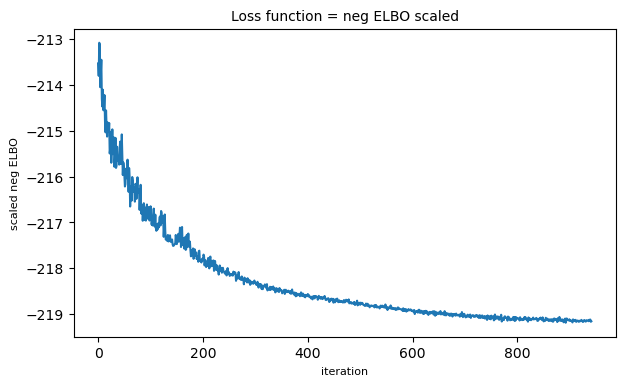

In [177]:
if not independent_outputs:
    fig, ax = plt.subplots(figsize=(7,4))
    loss_start = 100
    # ax.plot(np.arange(0, len(loss_array) - loss_start), loss_array[loss_start:])
    ax.plot(np.arange(0, i - loss_start), loss_array[loss_start:i])
    ax.set_xlabel(r"iteration", fontdict={'fontsize':8})
    ax.set_ylabel(r"scaled neg ELBO", fontdict={'fontsize':8})
    ax.set_title(r"Loss function = neg ELBO scaled", fontsize=10);
else:
    fig, ax1 = plt.subplots(figsize=(7,4), sharey=False)
    loss_start = 100
    lines = []
    labels = [f"loss for y_{q}" for q in range(5)]
    for q in range(5):
        if q == 0:
            ax = ax1
        else:
            ax = ax1.twinx()
        line = ax.plot(np.arange(0, len(loss_array[...,q]) - loss_start), loss_array[loss_start:,q], label=f"loss for y_{q}")
        ax.set_ylabel(labels[q])
        lines.append(line)
    # ax.set_ylim(0,.3)
    # ax.set_xlabel(r"iteration", fontdict={'fontsize':8})
    # ax.set_ylabel(r"scaled neg ELBO", fontdict={'fontsize':8})
    # ax.set_title(r"Loss function = neg ELBO scaled", fontsize=10);

In [178]:
def get_kernel_parameters(model, independent_outputs=False, prefix=""):

    kernel_parameters = collections.defaultdict(collections.defaultdict)

    if not independent_outputs:
        kernel_modules = model.covar_module.kernel_modules
    else:
        kernel_modules = model.covar_module.sub_kernels()
    
    for i, module in enumerate(kernel_modules):
        # Should always be True since we are using ScaleKernels
        k_parent = f"{prefix}Kernel.{i}"
        if isinstance(module, ScaleKernel):
            kernel = module.base_kernel
        else:
            kernel = module
        if isinstance(kernel, (ProductKernel, AdditiveKernel)):
            # Sub kernels within ProductKernel / AdditiveKernel
            for j, ksub in enumerate(kernel.kernels):
                op_kernel_str = kernel._get_name()
                k_name = f"{op_kernel_str}.{j}.{ksub._get_name()}"
                kernel_parameters[k_parent][k_name] = collections.defaultdict(dict)
                for name, raw_value, constraint in ksub.named_parameters_and_constraints():
                    param = name.split("_")[-1]
                    value = constraint.transform(raw_value).detach().cpu().flatten().numpy()
                    value = np.round(value, 4)
                    kernel_parameters[k_parent][k_name][param] = value
                if hasattr(ksub, "nu"):
                    kernel_parameters[k_parent][k_name]["nu"] = ksub.nu
        else:
            k_name = f"{kernel._get_name()}"
            kernel_parameters[k_parent][k_name] = collections.defaultdict(collections.defaultdict)
            for name, raw_value, constraint in kernel.named_parameters_and_constraints():
                    param = name.split("_")[-1]
                    value = constraint.transform(raw_value).detach().cpu().flatten().numpy()
                    value = np.round(value, 4)                    
                    kernel_parameters[k_parent][k_name][param] = value
            if hasattr(kernel, "nu"):
                kernel_parameters[k_parent][k_name]["nu"] = kernel.nu
        for name, raw_value, constraint in module.named_parameters_and_constraints():
            if "outputscale" in name:
                param = name.split("_")[-1]
                value = constraint.transform(raw_value).detach().cpu().flatten().numpy()
                value = np.round(value, 4)                    
                kernel_parameters[k_parent][param] = value
    
    return kernel_parameters

if not independent_outputs:
    kernel_parameters = get_kernel_parameters(model, independent_outputs=independent_outputs)
    lmc_dict["lmc_coeff"] = model.variational_strategy.lmc_coefficients.detach().cpu().flatten().numpy()
else:
    kernel_parameters = collections.defaultdict(collections.defaultdict)
    for i, m in enumerate(model_list):
        tmp = get_kernel_parameters(m, independent_outputs=independent_outputs, prefix=f"model_y{i}_")
        kernel_parameters.update(tmp)
        lmc_dict["lmc_coeff"] = 0

lengthscales_list = []
for key, val in kernel_parameters.items():
    for inner_key, inner_val in val.items():
        if isinstance(inner_val, collections.defaultdict):
            if "lengthscale" in inner_val.keys():
                lengthscales_list.extend(inner_val["lengthscale"])

lengthscales_dict["lengthscales"] = lengthscales_list

In [179]:
kernel_combination = []
kernel_combination_full = []
kernel_combination_dims = []
nu_map = {"0.5": "12", "1.5": "32", "2.5": "52"}

kernel_count = {
    "SE": 1,
    "M12": 1,
    "M32": 1,
    "M52": 1,
    "Lin": 1,
    "PPoly": 1,
    "Poly": 1,
    "RQ": 1,
    "RFF": 1,
}

def get_kernel_code(k_name):
    k_string = ""
    if "RBF" in k_name:
        k_string += "SE"
    elif "Matern" in k_name:
        k_string += "M"
    elif "Linear" in k_name:
        k_string += "Lin"
    elif "PiecewisePolynomialKernel" in k_name:
        k_string += "PPoly"
    elif "PolynomialKernel" in k_name:
        k_string += "Poly"
    elif "RQKernel" in k_name:
        k_string += "RQ"
    elif "RFFKernel" in k_name:
        k_string += "RFF"
    return k_string

def get_kernel_combination_dims(model):
    
    kernel_modules = model.covar_module.kernel_modules

    for i, module in enumerate(kernel_modules):
        k_string = ""
        if not independent_outputs:
            dim_str = str(active_dims[i][0])
        else:
            dim_str = "."
        if isinstance(module, ScaleKernel):
            kernel = module.base_kernel
        else:
            kernel = module
        if isinstance(kernel, (ProductKernel, AdditiveKernel)):
            # Sub kernels within ProductKernel / AdditiveKernel
            k_group = []
            for j, ksub in enumerate(kernel.kernels):
                k_name = str(ksub._get_name())
                if hasattr(ksub, "nu"):
                    nu = nu_map[str(ksub.nu)]
                    k_code = get_kernel_code(k_name)
                    k_code += nu
                else:
                    k_code = get_kernel_code(k_name)
                k_name = k_code + "_" + str(kernel_count[k_code]) + f"^({dim_str})"
                k_group.append(k_name)
                kernel_count[k_code] += 1
            kernel_combination.append(tuple(k_group))
            kernel_combination_full.append(" x ".join(k_group))
        else:
            k_name = str(kernel._get_name())
            if hasattr(kernel, "nu"):
                nu = nu_map[str(kernel.nu)]
                k_code = get_kernel_code(k_name)
                k_code += nu
            else:
                k_code = get_kernel_code(k_name)
                k_name = k_code
            k_name = k_code + "_" + str(kernel_count[k_code]) + f"^({dim_str})"
            kernel_count[k_code] += 1
            kernel_combination.append(k_name)
            kernel_combination_full.append(k_name)

    for i,k in enumerate(iterable=kernel_combination_full):
        if i == 0:
            k_name = kernel_combination_full[0]
            dim_pre = active_dims[0][0]
        elif i < len(kernel_combination_full)-1:
            dim = active_dims[i][0]
            if dim_pre == dim:
                k_name += f" + {k}"
            else:
                kernel_combination_dims.append(k_name)
                k_name = k
                dim_pre = dim
        else:
            k_name += f" + {k}"
            kernel_combination_dims.append(k_name)
    
    return kernel_combination_dims

if not independent_outputs:
    kernel_structure_dict["kernel_structure"] = get_kernel_combination_dims(model)
else:
    kernel_structure_dict["kernel_structure"] = ""
    
kernel_structure_dict["compute_time"] = compute_time

In [195]:
raw_mu_cutpoints = pyro.get_param_store()['mu_cutpoints'].detach()
raw_sd_cutpoints = pyro.get_param_store()['sd_cutpoints'].detach()

cutpoints_dist = dist.TransformedDistribution(
                        dist.Normal(raw_mu_cutpoints, raw_sd_cutpoints),
                        dist.transforms.OrderedTransform()
                    )
samples_cutpoints = cutpoints_dist.sample_n(1000)
mu_cutpoints = samples_cutpoints.mean(-2)
sd_cutpoints = samples_cutpoints.std(-2)
print(f"mu_cutpoints: {mu_cutpoints}")
print(f"sd_cutpoints: {sd_cutpoints}")

mu_cutpoints: tensor([-0.6567, -0.5411,  3.3401])
sd_cutpoints: tensor([0.0280, 0.0307, 0.0492])


In [197]:
# def compute_metrics(model):
#     # global independent_outputs
#     # global test_id
#     # global kcid
#     # global lmc_prior_code
#     # global lengthscale_prior_code
    
#     global loo_df
#     global loo_train_df
#     global nlpd_df
#     global agreement_df
#     global msce_df
    
loo_dict = collections.defaultdict(collections.defaultdict)
loo_train_dict = collections.defaultdict(collections.defaultdict)
nlpd_dict = collections.defaultdict(collections.defaultdict)
agreement_dict = collections.defaultdict(collections.defaultdict)
msce_dict = collections.defaultdict(collections.defaultdict)

stats_dictlist = [loo_dict, loo_train_dict, nlpd_dict,
                    agreement_dict, msce_dict]


for stats_dict in stats_dictlist:
    stats_dict["test_id"] = test_id
    stats_dict["kcid"] = kcid
    stats_dict["lmc_prior_code"] = lmc_prior_code
    stats_dict["lengthscale_prior_code"] = lengthscale_prior_code

# pyro.set_rng_seed(88)
# create samples
if not independent_outputs:
    # include return_sites in Predictive for faster execution
    predictive_dist = Predictive(model.model, guide=model.guide, num_samples=300)
    predictions = predictive_dist(test_x, None, n_categories=4, n_compositions=[4, 4])
    y0_pred = predictions["hmogp.y_0"].median(0)[0].squeeze(0).cpu().numpy()
    y1_pred = predictions['hmogp.y_1'].mean(0)[0].squeeze(0).cpu().numpy()
    y2_pred = predictions['hmogp.y_2'].mean(0)[0].squeeze(0).cpu().numpy()
    y3_pred = predictions['hmogp.y_3'].median(0)[0].squeeze(0).cpu().numpy()
    y4_pred = predictions['hmogp.y_4'].median(0)[0].squeeze(0).cpu().numpy()
    f_samples = predictions["hmogp.f(x)"].cpu()

    predictions_train = predictive_dist(train_x, None, n_categories=4, n_compositions=[4, 4])
    y0_pred_train = predictions_train["hmogp.y_0"].median(0)[0].squeeze(0).cpu().numpy()
    y1_pred_train = predictions_train["hmogp.y_1"].mean(0)[0].squeeze(0).cpu().numpy()
    y2_pred_train = predictions_train["hmogp.y_2"].mean(0)[0].squeeze(0).cpu().numpy()
    y3_pred_train = predictions_train["hmogp.y_3"].median(0)[0].squeeze(0).cpu().numpy()
    y4_pred_train = predictions_train["hmogp.y_4"].median(0)[0].squeeze(0).cpu().numpy()
    f_samples_train = predictions_train["hmogp.f(x)"].cpu()

else:
    predictive_dist = []
    predictive_dist_train = []
    y_preds = []
    y_preds_train = []
    f_samples = torch.empty((300,test_x.size(0), 16))
    f_samples_train = torch.empty((300,train_x.size(0), 16))
    dims = [list(range(4)), list(range(4,9)), list(range(9,14)), [14],[15]]
    for i, model in enumerate(model_list):
        predictive_dist = Predictive(model.model, guide=model.guide, num_samples=300)
        predictions = predictive_dist(test_x, None, n_categories=4, n_compositions=[4, 4])
        predictions_train = predictive_dist(train_x, None, n_categories=4, n_compositions=[4, 4])
        # each pred is now hmogp.y_0 because d_counter will always be equal to 0
        if i in [1, 2]:
            pred = predictions[f"hmogp.y_0"].mean(0)[0].squeeze(0).cpu().numpy()
            pred_train = predictions_train[f"hmogp.y_0"].mean(0)[0].squeeze(0).cpu().numpy()
        elif i in [0, 3, 4]:
            pred = predictions[f'hmogp.y_0'].median(0)[0].squeeze(0).cpu().numpy()
            pred_train = predictions_train[f"hmogp.y_0"].mode(0)[0].squeeze(0).cpu().numpy()
        y_preds.append(pred)
        y_preds_train.append(pred_train)
        f_samples[...,dims[i]] = predictions["hmogp.f(x)"].cpu()
        f_samples_train[...,dims[i]] = predictions_train["hmogp.f(x)"].cpu()          
        # break
        
# compute log likelihoods
log_likelihood = compute_log_likelihood(f_samples, likelihoods, test_y, n_compositions=[4,4], cutoff_pts=mu_cutpoints)
log_likelihood_xr = xr.Dataset(
    {"log_likelihood": (("chain", "draw", "index", "response"), np.expand_dims(log_likelihood, axis=0))},
    coords={
        "chain": [0],
        "draw": np.arange(log_likelihood.shape[0]),
        "index": np.arange(log_likelihood.shape[1]),
        "response": [f"y{d}" for d in range(log_likelihood.shape[2])]
    }
)
posterior_xr = xr.Dataset(
    {"lpf_iq": (("chain", "draw", "index", "q"), f_samples.unsqueeze(0).numpy())},
    coords={
        "chain": [0],
        "draw": np.arange(f_samples.shape[0]),
        "index": np.arange(f_samples.shape[1]),
        "q": np.arange(f_samples.shape[-1]),
    }
)
az_data = az.InferenceData(log_likelihood=log_likelihood_xr,
                        posterior=posterior_xr)

# train data
log_likelihood_train = compute_log_likelihood(f_samples_train, likelihoods, train_y, n_compositions=[4,4], cutoff_pts=mu_cutpoints)

log_likelihood_xr_train = xr.Dataset(
    {"log_likelihood": (("chain", "draw", "index", "response"), np.expand_dims(log_likelihood_train, axis=0))},
    coords={
        "chain": [0],
        "draw": np.arange(log_likelihood_train.shape[0]),
        "index": np.arange(log_likelihood_train.shape[1]),
        "response": [f"y{d}" for d in range(log_likelihood_train.shape[2])]
    }
)
posterior_xr_train = xr.Dataset(
    {"lpf_iq": (("chain", "draw", "index", "q"), f_samples_train.unsqueeze(0).numpy())},
    coords={
        "chain": [0],
        "draw": np.arange(f_samples_train.shape[0]),
        "index": np.arange(f_samples_train.shape[1]),
        "q": np.arange(f_samples_train.shape[-1]),
    }
)
az_data_train = az.InferenceData(log_likelihood=log_likelihood_xr_train,
                        posterior=posterior_xr_train)
# compute loo
test_loo = az.loo(az_data, pointwise=True)
train_loo = az.loo(az_data_train, pointwise=True)

In [159]:
# ll = compute_log_likelihood(f_samples.mean(0).unsqueeze(0), likelihoods, test_y, n_compositions=[4,4])
# nlpd0 = compute_nlpd(ll, test_y)

In [66]:
log_likelihood_xr0 = xr.Dataset(
    {"log_likelihood": (("chain", "draw", "index"), np.expand_dims(log_likelihood[...,0], axis=0))},
    coords={
        "chain": [0],
        "draw": np.arange(log_likelihood.shape[0]),
        "index": np.arange(log_likelihood.shape[1])
    }
)
posterior_xr0 = xr.Dataset(
    {"lpf_iq": (("chain", "draw", "index", "q"), f_samples.unsqueeze(0).numpy()[...,:4])},
    coords={
        "chain": [0],
        "draw": np.arange(f_samples.shape[0]),
        "index": np.arange(f_samples.shape[1]),
        "q": np.arange(4),
    }
)
az_data0 = az.InferenceData(log_likelihood=log_likelihood_xr0,
                        posterior=posterior_xr0)


log_likelihood_xr1 = xr.Dataset(
    {"log_likelihood": (("chain", "draw", "index"), np.expand_dims(log_likelihood[...,1], axis=0))},
    coords={
        "chain": [0],
        "draw": np.arange(log_likelihood.shape[0]),
        "index": np.arange(log_likelihood.shape[1])
    }
)
posterior_xr1 = xr.Dataset(
    {"lpf_iq": (("chain", "draw", "index", "q"), f_samples.unsqueeze(0).numpy()[...,4:9])},
    coords={
        "chain": [0],
        "draw": np.arange(f_samples.shape[0]),
        "index": np.arange(f_samples.shape[1]),
        "q": np.arange(5),
    }
)
az_data1 = az.InferenceData(log_likelihood=log_likelihood_xr1,
                        posterior=posterior_xr1)


log_likelihood_xr2 = xr.Dataset(
    {"log_likelihood": (("chain", "draw", "index"), np.expand_dims(log_likelihood[...,2], axis=0))},
    coords={
        "chain": [0],
        "draw": np.arange(log_likelihood.shape[0]),
        "index": np.arange(log_likelihood.shape[1])
    }
)
posterior_xr2 = xr.Dataset(
    {"lpf_iq": (("chain", "draw", "index", "q"), f_samples.unsqueeze(0).numpy()[...,9:14])},
    coords={
        "chain": [0],
        "draw": np.arange(f_samples.shape[0]),
        "index": np.arange(f_samples.shape[1]),
        "q": np.arange(5),
    }
)
az_data2 = az.InferenceData(log_likelihood=log_likelihood_xr2,
                        posterior=posterior_xr2)



log_likelihood_xr3 = xr.Dataset(
    {"log_likelihood": (("chain", "draw", "index"), np.expand_dims(log_likelihood[...,3], axis=0))},
    coords={
        "chain": [0],
        "draw": np.arange(log_likelihood.shape[0]),
        "index": np.arange(log_likelihood.shape[1])
    }
)
posterior_xr3 = xr.Dataset(
    {"lpf_iq": (("chain", "draw", "index", "q"), f_samples.unsqueeze(0).numpy()[...,14:15])},
    coords={
        "chain": [0],
        "draw": np.arange(f_samples.shape[0]),
        "index": np.arange(f_samples.shape[1]),
        "q": np.arange(1),
    }
)
az_data3 = az.InferenceData(log_likelihood=log_likelihood_xr3,
                        posterior=posterior_xr3)


log_likelihood_xr4 = xr.Dataset(
    {"log_likelihood": (("chain", "draw", "index"), np.expand_dims(log_likelihood[...,4], axis=0))},
    coords={
        "chain": [0],
        "draw": np.arange(log_likelihood.shape[0]),
        "index": np.arange(log_likelihood.shape[1])
    }
)
posterior_xr4 = xr.Dataset(
    {"lpf_iq": (("chain", "draw", "index", "q"), f_samples.unsqueeze(0).numpy()[...,15:])},
    coords={
        "chain": [0],
        "draw": np.arange(f_samples.shape[0]),
        "index": np.arange(f_samples.shape[1]),
        "q": np.arange(1),
    }
)
az_data4 = az.InferenceData(log_likelihood=log_likelihood_xr4,
                        posterior=posterior_xr4)

In [199]:
az.loo(az_data)

Computed from 300 posterior samples and 1960 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  8778.73   284.08
p_loo       13.55        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     1572   80.2%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)  388   19.8%

In [198]:
az.waic(az_data)

Computed from 300 posterior samples and 1960 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  8778.91   284.09
p_waic       13.37        -

In [68]:
log_likelihood.shape

(300, 392, 5)

In [69]:
log_likelihood.var(0).sum(0).sum()

135.22854135617814

In [70]:
loo0 = az.loo(az_data0, pointwise=True)
loo1 = az.loo(az_data1, pointwise=True)
loo2 = az.loo(az_data2, pointwise=True)
loo3 = az.loo(az_data3, pointwise=True)
loo4 = az.loo(az_data4, pointwise=True)

print("loo0: \n", loo0, "\n")
print("loo1: \n", loo1, "\n")
print("loo2: \n", loo2, "\n")
print("loo3: \n", loo3, "\n")
print("loo4: \n", loo4, "\n")

loo0: 
 Computed from 300 posterior samples and 392 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -292.30    17.49
p_loo       26.69        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      390   99.5%
 (0.5, 0.7]   (ok)          1    0.3%
   (0.7, 1]   (bad)         1    0.3%
   (1, Inf)   (very bad)    0    0.0%
 

loo1: 
 Computed from 300 posterior samples and 392 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  4531.53    78.05
p_loo       30.47        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      378   96.4%
 (0.5, 0.7]   (ok)         14    3.6%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%
 

loo2: 
 Computed from 300 posterior samples and 392 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  

In [200]:
f_samples_mean = f_samples.mean(0)

IndexError: index 15 is out of bounds for dimension 1 with size 13

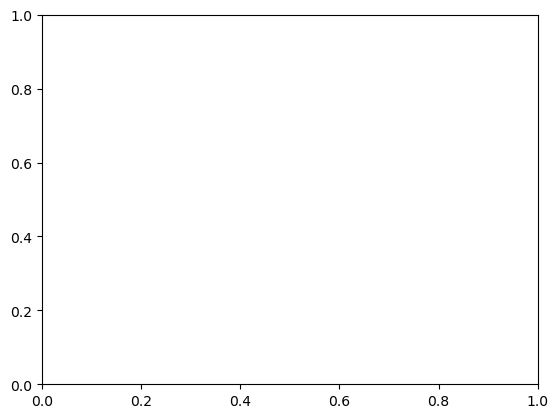

In [201]:
fig, ax = plt.subplots()

i =3

pareto_bad = np.where(loo4.pareto_k.values == np.inf)[0]    
test_x_pareto_bad = test_x[pareto_bad, i]
x_pareto_bad = np.argsort(test_x_pareto_bad)
test_y_pareto_bad = test_y[pareto_bad,10]
test_y_pareto_bad = test_y_pareto_bad[x_pareto_bad]
ax.scatter(test_x_pareto_bad[x_pareto_bad], f_samples_mean[x_pareto_bad,15], c=test_y_pareto_bad)

pareto_good = np.where(loo4.pareto_k.values != np.inf)[0]   
test_x_pareto_good = test_x[pareto_good, i]
x_pareto_good = np.argsort(test_x_pareto_good)
test_y_pareto_good = test_y[pareto_good,10]
test_y_pareto_good = test_y_pareto_good[x_pareto_good]
ax.scatter(test_x_pareto_good[x_pareto_good], f_samples_mean[x_pareto_good,15], c=test_y_pareto_good)

In [73]:
test_loo

Computed from 300 posterior samples and 1960 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  8658.24   282.49
p_loo      139.20        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     1419   72.4%
 (0.5, 0.7]   (ok)        256   13.1%
   (0.7, 1]   (bad)       161    8.2%
   (1, Inf)   (very bad)  124    6.3%

In [204]:
bins = np.asarray([-np.Inf, 0.5, 0.7, 1, np.Inf])
pareto_k, _ = np.histogram(test_loo.pareto_k.values, bins=bins)
pareto_k_train, _ = np.histogram(train_loo.pareto_k.values, bins=bins)

test_loo = test_loo.to_dict()
train_loo = train_loo.to_dict()

# update_keys = list(set(test_loo.keys()) - {"loo_i", "pareto_k"})
k = [f"elpd_loo_y{i}" for i in range(5)]
loo_i = test_loo["loo_i"].values.sum(0)
loo_i_dict = {k:round(v,5) for (k,v) in zip(k, loo_i)}
loo_i_train = train_loo["loo_i"].values.sum(0)
loo_i_train_dict = {k:round(v,5) for (k,v) in zip(k, loo_i_train)}
remove_keys = ["loo_i", "pareto_k"]
for key in remove_keys:
    test_loo.pop(key, None)
    train_loo.pop(key, None)

for i, label in enumerate(pareto_k_label):
    test_loo[label] = pareto_k[i]
    train_loo[label] = pareto_k_train[i]

loo_dict["test_data"] = 1
loo_train_dict["test_data"] = 0
loo_dict.update(test_loo)
loo_dict.update(loo_i_dict)
loo_train_dict.update(train_loo)
loo_train_dict.update(loo_i_train_dict)

# compute nlpd
nlpd_scores = compute_nlpd(log_likelihood, test_y)
for key,val in zip(["y" + str(i) for i in range(5)],nlpd_scores):
    nlpd_dict[key] = val
    
# compute msce
y0_test = test_y[...,0].numpy()
y1_test = test_y[...,1:5].numpy()
y2_test = test_y[...,5:9].numpy()
y3_test = test_y[...,9].numpy()
y4_test = test_y[...,10].numpy()

if independent_outputs:
    y1_pred = y_preds[1]
    y2_pred = y_preds[2]
    
y1_msce = mean_sum_composition_errors(y1_pred, y1_test)
y2_msce = mean_sum_composition_errors(y2_pred, y2_test)

msce_dict["y1"] = y1_msce
msce_dict["y2"] = y2_msce

# compute agreements
weight_type = ["unweighted", "linear", "quadratic"]
y_class = ["y0", "y3", "y4"]
y_test_class = [y0_test, y3_test, y4_test]

if independent_outputs:
    y0_pred = y_preds[0]
    y3_pred = y_preds[3]
    y4_pred = y_preds[4]
    
y_pred_class = [y0_pred, y3_pred, y4_pred]

for weight in weight_type:
    for y, y_test, y_pred in zip(y_class, y_test_class, y_pred_class):
        cm = confusion_matrix(y_test, y_pred)
        agreement_dict["weight"] = weight
        agreement_dict[y] = scotts_pi(cm, weight_type=weight)
    agreement_df = agreement_df.append(agreement_dict, ignore_index=True)

loo_df = loo_df.append(loo_dict, ignore_index=True)
loo_train_df = loo_train_df.append(loo_train_dict, ignore_index=True)
nlpd_df = nlpd_df.append(nlpd_dict, ignore_index=True)
msce_df = msce_df.append(msce_dict, ignore_index=True)

print("Metrics compute: Done!")

Metrics compute: Done!


In [205]:
agreement_df

,test_id,kcid,lmc_prior_code,lengthscale_prior_code,weight,y0,y3,y4
0,330,0,2,1,unweighted,0.1060,0.944,0.8828
1,330,0,2,1,linear,0.5501,0.944,0.8828
2,330,0,2,1,quadratic,0.7474,0.944,0.8828


In [75]:
lengthscales_df = lengthscales_df.append(lengthscales_dict, ignore_index=True)
lmc_df = lmc_df.append(lmc_dict, ignore_index=True)
kernel_structure_df = kernel_structure_df.append(kernel_structure_dict, ignore_index=True)

In [76]:
# do multiprocessing here

# compute_metrics(model)

In [126]:
agreement_df[agreement_df.weight=="quadratic"].groupby(by="test_id", as_index=False).mean()

,test_id,y0,y3,y4
0,0,0.8276,0.7674,0.8828


In [77]:
testing = agreement_df[agreement_df.weight=="quadratic"].groupby(by="test_id", as_index=True)["y0", "y3", "y4"].agg(["mean", "std"])
testing.columns = testing.columns.droplevel(0)
testing.reset_index(inplace=True)
testing.columns = ["test_id"] + [f"{stat}_y{i}" for stat in ["mean", "std"] for i in [0,3,4]]
testing

,test_id,mean_y0,mean_y3,mean_y4,std_y0,std_y3,std_y4
0,2,0.7855,NaN,0.891,NaN,0.8473,NaN


HD: record run times for comparison

In [77]:
nlpd_df

,test_id,kcid,lmc_prior_code,lengthscale_prior_code,y0,y1,y2,y3,y4
0,330.0,0.0,2.0,1.0,0.708958,-11.602041,-11.598079,0.089387,0.106389


In [217]:
# lmc_list = []
# for model in model_list:
#     coeff = model.variational_strategy.lmc_coefficients.detach().cpu().flatten().numpy()
#     lmc_list.append(coeff)
# lmc_dict["lmc_coeff"] = lmc_list

In [78]:
f_samples_train_mean = f_samples_train.mean(0)

outcome_l = [
    'Red Win',
    'RedBlue Killed',
    'RedBlue Survived',
    'Blue Win', 
    'Blue Neutral',
    'Blue Defense',
    'Blue Headon', 
    'Blue Offense',
    'Blue State Precision',
    'Red Neutral', 
    'Red Defense', 
    'Red Headon', 
    'Red Offense',
    'Red State Precision',
    "Blue Launched",
    "Red Launched",
]

corr = pd.DataFrame(data=f_samples_train_mean, columns=outcome_l)


In [558]:
def magnify():
    return [dict(selector="th",
                 props=[("font-size", "4pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])]   
cmap = sns.diverging_palette(5, 250, as_cmap=True)

In [559]:

corr_plot = corr.corr()
corr_plot.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magnify")\
    .format(precision=2)\
    .set_table_styles(magnify())

,Red Win,RedBlue Killed,RedBlue Survived,Blue Win,Blue Neutral,Blue Defense,Blue Headon,Blue Offense,Blue State Precision,Red Neutral,Red Defense,Red Headon,Red Offense,Red State Precision,Blue Launched,Red Launched
Red Win,1.00,-0.06,-0.05,-0.44,-0.29,0.22,0.08,-0.47,0.32,0.18,-0.30,0.37,0.47,0.32,-0.52,0.71
RedBlue Killed,-0.06,1.00,-0.22,-0.02,-0.81,-0.26,-0.15,-0.30,0.27,-0.70,-0.28,0.01,-0.10,0.26,0.02,0.10
RedBlue Survived,-0.05,-0.22,1.00,-0.67,0.42,0.44,-0.77,0.22,-0.90,-0.07,-0.06,-0.88,0.03,-0.89,-0.36,-0.11
Blue Win,-0.44,-0.02,-0.67,1.00,0.10,-0.75,0.82,0.52,0.53,0.06,0.66,0.55,-0.63,0.52,0.77,-0.47
Blue Neutral,-0.29,-0.81,0.42,0.10,1.00,0.20,0.01,0.54,-0.57,0.70,0.47,-0.24,-0.07,-0.56,0.28,-0.52
Blue Defense,0.22,-0.26,0.44,-0.75,0.20,1.00,-0.52,-0.59,-0.47,0.34,-0.70,-0.29,0.87,-0.46,-0.39,0.12
Blue Headon,0.08,-0.15,-0.77,0.82,0.01,-0.52,1.00,0.24,0.77,0.26,0.48,0.87,-0.26,0.76,0.65,-0.23
Blue Offense,-0.47,-0.30,0.22,0.52,0.54,-0.59,0.24,1.00,-0.19,-0.01,0.93,-0.21,-0.84,-0.18,0.56,-0.63
Blue State Precision,0.32,0.27,-0.90,0.53,-0.57,-0.47,0.77,-0.19,1.00,-0.12,0.09,0.88,-0.07,1.00,0.26,0.25
Red Neutral,0.18,-0.70,-0.07,0.06,0.70,0.34,0.26,-0.01,-0.12,1.00,0.14,0.34,0.41,-0.10,0.14,-0.13


In [560]:
corr_plot = corr.corr(method="spearman")
corr_plot.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magnify")\
    .format(precision=2)\
    .set_table_styles(magnify())

,Red Win,RedBlue Killed,RedBlue Survived,Blue Win,Blue Neutral,Blue Defense,Blue Headon,Blue Offense,Blue State Precision,Red Neutral,Red Defense,Red Headon,Red Offense,Red State Precision,Blue Launched,Red Launched
Red Win,1.00,-0.06,-0.05,-0.41,-0.29,0.23,0.08,-0.47,0.29,0.17,-0.29,0.37,0.47,0.30,-0.50,0.69
RedBlue Killed,-0.06,1.00,-0.17,-0.02,-0.80,-0.26,-0.13,-0.29,0.22,-0.70,-0.27,0.01,-0.11,0.21,-0.00,0.09
RedBlue Survived,-0.05,-0.17,1.00,-0.66,0.35,0.37,-0.78,0.22,-0.87,-0.11,-0.05,-0.89,0.00,-0.86,-0.38,-0.08
Blue Win,-0.41,-0.02,-0.66,1.00,0.09,-0.74,0.82,0.52,0.57,0.05,0.66,0.53,-0.63,0.55,0.75,-0.45
Blue Neutral,-0.29,-0.80,0.35,0.09,1.00,0.18,0.00,0.54,-0.50,0.70,0.45,-0.23,-0.07,-0.50,0.29,-0.52
Blue Defense,0.23,-0.26,0.37,-0.74,0.18,1.00,-0.50,-0.60,-0.47,0.32,-0.70,-0.25,0.87,-0.45,-0.37,0.14
Blue Headon,0.08,-0.13,-0.78,0.82,0.00,-0.50,1.00,0.23,0.80,0.24,0.47,0.85,-0.27,0.78,0.63,-0.22
Blue Offense,-0.47,-0.29,0.22,0.52,0.54,-0.60,0.23,1.00,-0.14,-0.00,0.93,-0.23,-0.83,-0.14,0.53,-0.62
Blue State Precision,0.29,0.22,-0.87,0.57,-0.50,-0.47,0.80,-0.14,1.00,-0.09,0.15,0.87,-0.12,1.00,0.29,0.21
Red Neutral,0.17,-0.70,-0.11,0.05,0.70,0.32,0.24,-0.00,-0.09,1.00,0.13,0.32,0.40,-0.09,0.15,-0.13


In [435]:
# different ways of measuring parsimonious model

print("as_is:",np.abs(lmc_coeffs["0"]["01"]).sum())
print("sqrt:", np.sqrt(np.abs(lmc_coeffs["0"]["01"])).sum())
print("log:",np.log(np.abs(lmc_coeffs["0"]["01"])).sum())
print("norm:", np.linalg.norm(np.abs(lmc_coeffs["0"]["01"])))

NameError: name 'lmc_coeffs' is not defined

In [436]:
# different ways of measuring parsimonious model

print("as_is:",np.abs(lmc_coeffs["0"]["21"]).sum())
print("sqrt:", np.sqrt(np.abs(lmc_coeffs["0"]["21"])).sum())
print("log:",np.log(np.abs(lmc_coeffs["0"]["21"])).sum())
print("norm:", np.linalg.norm(np.abs(lmc_coeffs["0"]["21"])))

NameError: name 'lmc_coeffs' is not defined

In [437]:
# how to measure cross-correlation?

sig1 = np.array(predictions_train["hmogp.f(x)"].mean(0)[...,0])
sig2 = np.array(predictions_train["hmogp.f(x)"].mean(0)[...,1])

 np.convolve(sig1, sig2)


IndentationError: unexpected indent (978367467.py, line 6)

Evaluating the model

In [438]:
train_x, train_y, test_x, test_y = train_x.cpu(), train_y.cpu(), test_x.cpu(), test_y.cpu()

(0.0, 1.0)

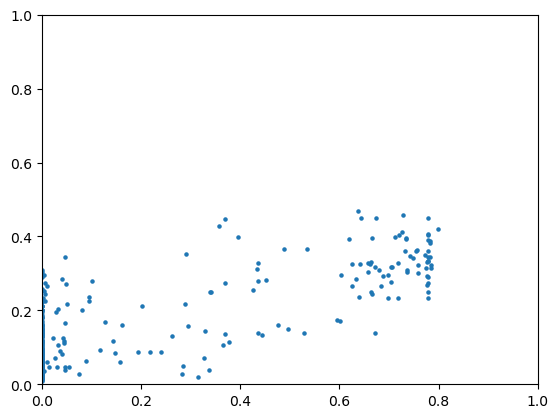

In [212]:
fig, ax = plt.subplots()

p = 3
ax.scatter(test_y[...,p+1], y1_pred[...,p], s=5)
ax.set_xlim(0,1)
ax.set_ylim(0,1)

(0.0, 1.0)

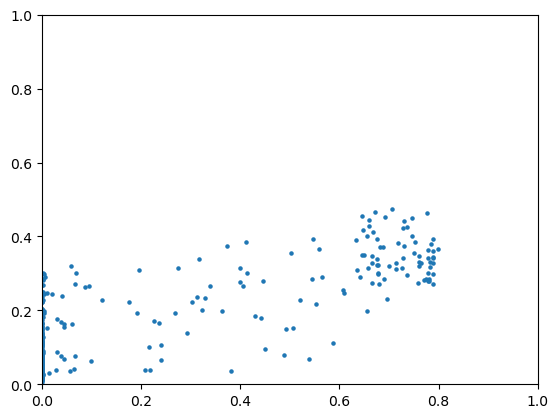

In [213]:
fig, ax = plt.subplots()

p = 3
ax.scatter(test_y[...,p+5], y2_pred[...,p], s=5)
ax.set_xlim(0,1)
ax.set_ylim(0,1)

(0.0, 1.0)

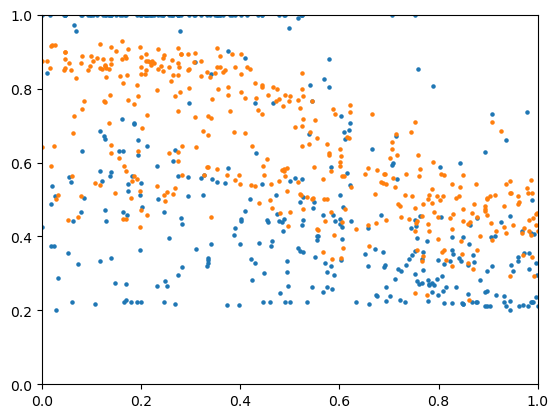

In [214]:
fig, ax = plt.subplots()

i = 1
p = 2
ax.scatter(test_x[...,i], test_y[...,p+1], s=5)
ax.scatter(test_x[...,i], y1_pred[...,p], s=5)
ax.set_xlim(0,1)
ax.set_ylim(0,1)

(0.0, 1.0)

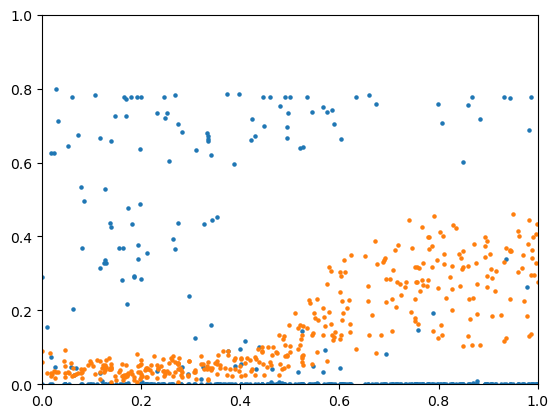

In [215]:
fig, ax = plt.subplots()

i = 1
p = 1
ax.scatter(test_x[...,i], test_y[...,p+5], s=5)
ax.scatter(test_x[...,i], y1_pred[...,p], s=5)
ax.set_xlim(0,1)
ax.set_ylim(0,1)

In [83]:
def percentiles_from_samples(samples, percentiles=[0.05, 0.5, 0.95]):
    num_samples = samples.size(0)
    samples = samples.sort(dim=0)[0]
    
    # Get samples corresponding to percentile
    percentile_samples = [samples[int(num_samples * percentile)] for percentile in percentiles]

    # Smooth the samples
    kernel = torch.full((1, 1, 5), fill_value=0.2)
    percentiles_samples = [
        torch.nn.functional.conv1d(percentile_sample.view(1, 1, -1), kernel, padding=2).view(-1)
        for percentile_sample in percentile_samples
    ]

    return percentile_samples

In [193]:
# # posterior predictive dist with outputs of size x.size()
# def ppd_given_input(model, x, n_samples=1000):
#     x_ = x
#     # if not x.is_cuda:
#         # x_ = x.cuda()
    
#     model.eval()
#     with torch.no_grad():
#         ppd = model(x_)

#     return ppd

# # obtain samples from ppd. get median or samples
# def sample_from_ppd(ppd, n_samples=1000, return_median=True):
#     samples = ppd.sample_n(n_samples)
#     if return_median: 
#         return samples.mode(0)[0]
#     else:
#         return samples

# lpf_ppd = ppd_given_input(
#     model=model,
#     x=test_x,
# )

# lpf_lower, lpf_upper = lpf_ppd.confidence_region()
# lpf_mean = lpf_ppd.mean
# lpf_lower, lpf_upper, lpf_mean = lpf_lower.cpu(), lpf_upper.cpu(), lpf_mean.cpu()

# lpf_ppd_train = ppd_given_input(
#     model=model,
#     x=train_x,
# )

# lpf_lower_train, lpf_upper_train = lpf_ppd_train.confidence_region()
# lpf_mean_train = lpf_ppd_train.mean
# lpf_lower_train, lpf_upper_train, lpf_mean_train = lpf_lower_train.cpu(), lpf_upper_train.cpu(), lpf_mean_train.cpu()

# # ppd of observations
# y1_ppd = dist.OrderedLogistic(lpf_mean, mu_cutpoints).to_event(1)
# y1_ppd_train = dist.OrderedLogistic(lpf_mean_train, mu_cutpoints).to_event(1)

In [194]:
# # Draw some simulated y values
# y_sim = torch.stack(
#     [sample_from_ppd(y1_ppd)],
#     dim=-1
# ).squeeze(-1)
# y_sim_train = torch.stack(
#     [sample_from_ppd(y1_ppd_train)],
#     dim=-1
# ).squeeze(-1)

The misclassification rate for Mutual Kill reduces when adding y_1 and y_2 proportions into the model

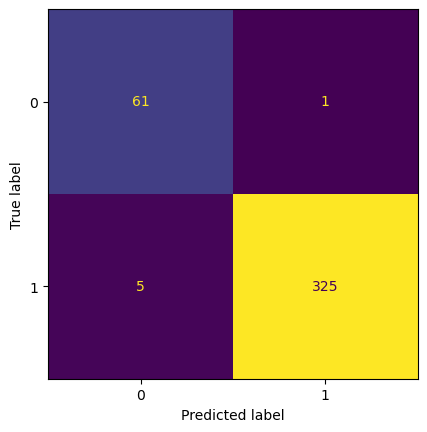

In [216]:
# outcome from using log_norm transformation
cm_test = confusion_matrix(test_y[...,-2], y3_pred)
cm_display = ConfusionMatrixDisplay(cm_test).plot(colorbar=False)
# plt.xticks(rotation=90);

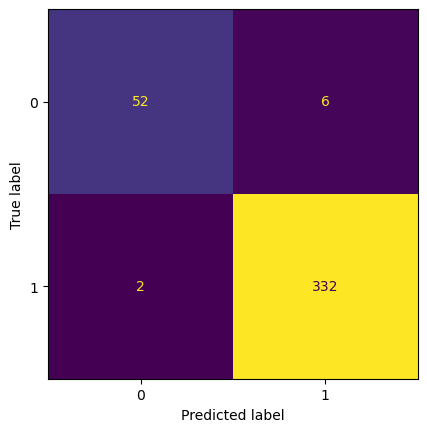

In [630]:
# outcome from using log_norm transformation
cm_test = confusion_matrix(test_y[...,-1], y4_pred)
cm_display = ConfusionMatrixDisplay(cm_test).plot(colorbar=False)
# plt.xticks(rotation=90);

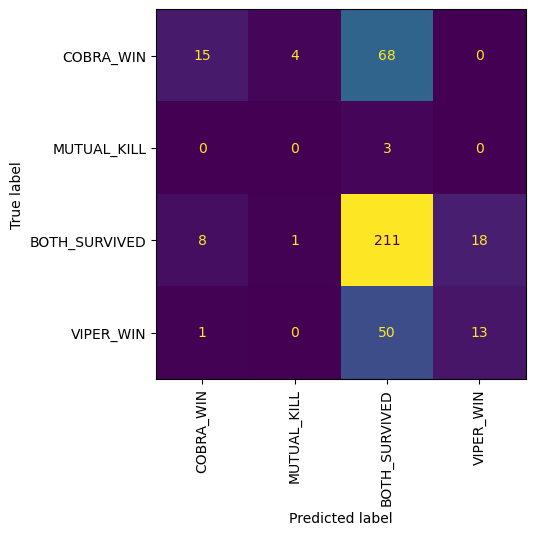

In [217]:
# outcome from using log_norm transformation
cm_outcomes = list(outcome_map.keys())[::-1]
cm_test = confusion_matrix(test_y[...,0], y0_pred)
cm_display = ConfusionMatrixDisplay(cm_test, display_labels=cm_outcomes).plot(colorbar=False)
plt.xticks(rotation=90);

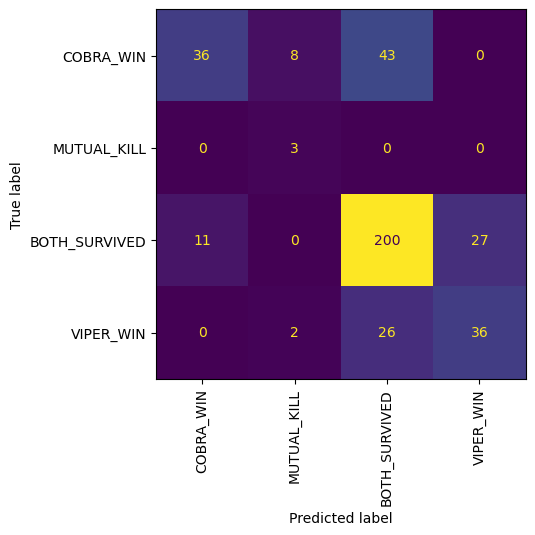

In [85]:
# outcome from using log_norm transformation
cm_outcomes = list(outcome_map.keys())[::-1]
cm_test = confusion_matrix(test_y[...,0], y0_pred)
cm_display = ConfusionMatrixDisplay(cm_test, display_labels=cm_outcomes).plot(colorbar=False)
plt.xticks(rotation=90);

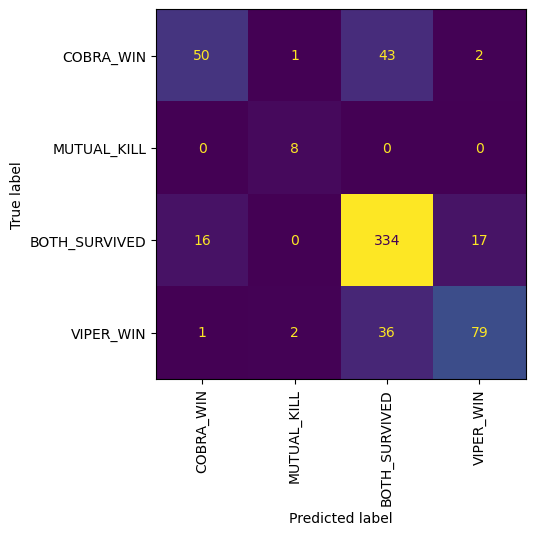

In [1049]:
# outcome from using log_norm transformation
cm_train = confusion_matrix(train_y[...,0], y0_pred_train)
cm_display = ConfusionMatrixDisplay(cm_train, display_labels=cm_outcomes).plot(colorbar=False)
plt.xticks(rotation=90);

Analyse (1) independent latent function, and (2) latent parameter functions

In [86]:
model.eval()

with torch.no_grad():
    ind_latent_fn = model.variational_strategy.ind_latent_fn
    lmc_coefficients = model.variational_strategy.lmc_coefficients
    lmc_coefficients = lmc_coefficients.cpu().detach()

ilf_lower, ilf_upper = ind_latent_fn.confidence_region()
ilf_mean = ind_latent_fn.mean
# ilf_lower, ilf_upper, ilf_mean = ilf_lower.cpu(), ilf_upper.cpu(), ilf_mean.cpu()
ilf_lower, ilf_upper, ilf_mean = ilf_lower.detach().cpu(), ilf_upper.detach().cpu(), ilf_mean.detach().cpu()

In [87]:
def eigen(lmc_coefficients, norm=True, round=5):
    
    V_mat = lmc_coefficients.T @ lmc_coefficients
    if norm:
        V_mat = torch.divide(V_mat, torch.norm(V_mat, dim=-1).unsqueeze(-1))
    V_eigval, V_eigvec = np.linalg.eig(V_mat)
    idx_sort = np.argsort(V_eigval)[::-1]
    V_eigval, V_eigvec = V_eigval[idx_sort], V_eigvec[:,idx_sort]
    V_eigval, V_eigvec = np.round(V_eigval, round), np.round(V_eigvec, round)

    return V_eigval, V_eigvec

In [88]:
V_mat = lmc_coefficients.T @ lmc_coefficients
V_eigval, V_eigvec = np.linalg.eig(V_mat)

In [89]:
outcome_l = [
    'Red Win',
    'RedBlue Killed',
    'RedBlue Survived',
    'Blue Win', 
    'Blue Neutral',
    'Blue Defense',
    'Blue Headon', 
    'Blue Offense',
    'Red Neutral', 
    'Red Defense', 
    'Red Headon', 
    'Red Offense',
    "Blue Launched",
    "Red Launched",
]

c_map = {
    'Red Win': "red",
    'RedBlue Killed': "orange",
    'RedBlue Survived': "grey",
    'Blue Win': "blue", 
    'Blue Neutral': "blue",
    'Blue Defense': "blue",
    'Blue Headon': "blue", 
    'Blue Offense': "blue",
    'Red Neutral': "red", 
    'Red Defense': "red", 
    'Red Headon': "red", 
    'Red Offense': "red",
    'Blue Launched': "blue",
    'Red Launched': "red",    
}

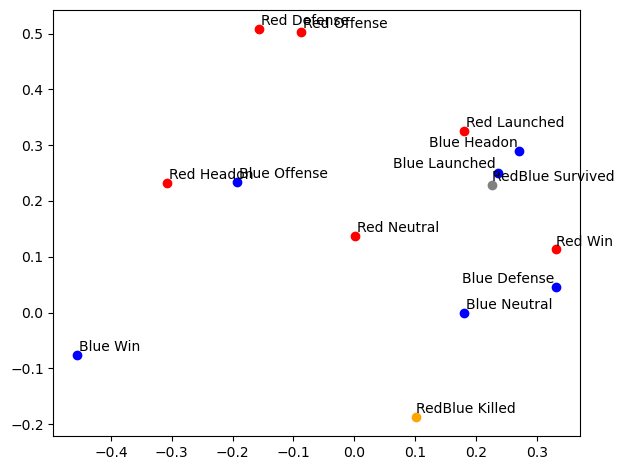

In [1055]:
eigval, eigvec = eigen(lmc_coefficients, norm=True)
fig, ax = plt.subplots()
for i in range(len(outcome_l)):
    x = eigvec[i,0]
    y = eigvec[i,1]
    ax.scatter(x=x, y=y, c=c_map[outcome_l[i]])
    text = [ax.text(x, y, outcome_l[i])]
    adjust_text(text)
fig.tight_layout()
# ax.set_xlim(-1,1)
# ax.set_ylim(-1,1);

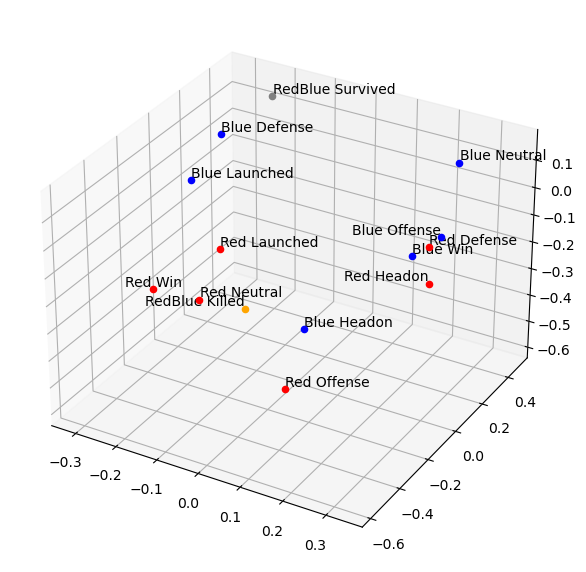

In [574]:
fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection='3d')

for i in range(len(outcome_l)):
    x = eigvec[i,0]
    y = eigvec[i,1]
    z = eigvec[i,2]
    ax.scatter3D(x, y, z, c=c_map[outcome_l[i]])
    # ax.text(x, y, z, outcome_l[i])
    text = [ax.text(x, y, z, outcome_l[i])]
    adjust_text(text)
    
fig.tight_layout()

HD: Including variance explained for each PCA component

<AxesSubplot: >

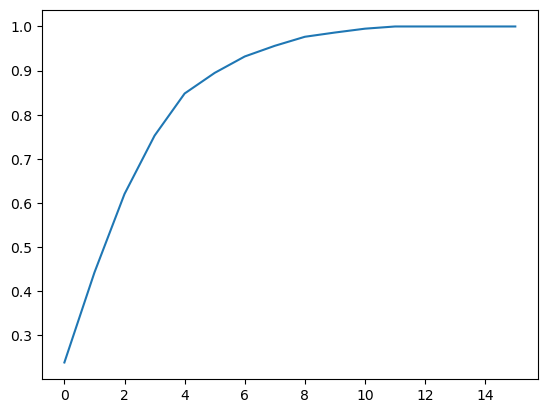

In [512]:
r_squared = np.cumsum(eigval / eigval.sum())
sns.lineplot(x=np.arange(len(eigval)), y=r_squared)

<AxesSubplot: >

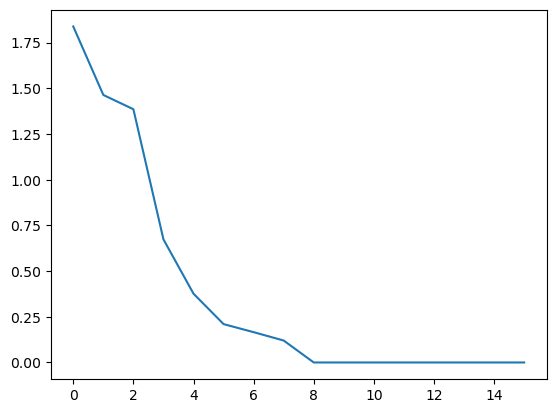

In [206]:
sns.lineplot(x=np.arange(len(eigval)), y=eigval)

In [90]:
inputs = [
    # "viper_launched",
    # 'viper_launch_range',
    'viper_briefed_launch_range',
    'viper_briefed_evasion_range',
    # "cobra_launched",
    # 'cobra_launch_range',
    'cobra_briefed_launch_range',
    'cobra_briefed_evasion_range',
    # 'launch_range_diff',
    # 'evasion_range_diff'
]

In [91]:
# # visualize the result
# input_dim = train_x.size(-1)
# num_latents = ilf_mean.size(0)
# n_categories = 4

# # visualize the result
# fig, func = plt.subplots(nrows=num_latents, ncols=1, figsize=(20, 20), sharey=True)
# # x="x"

# # for j in range(input_dim):
# row = 0
# for i in range(num_latents):
#     print(i, j)
#     # if j == active_dims[i][0]:
#     indices = np.argsort(train_x[:,j])
#     line = func[row].scatter(train_x[indices,j], ilf_mean[i,indices], alpha=0.3)
#     func[row].fill_between(
#         train_x[indices,j], ilf_lower[i,indices],
#         ilf_upper[i,indices], alpha=0.1, #color=line.get_color()
#     )
#     # func[row,j].set_xlabel(f"${{\mathbf{{x}}_{{{j+1}}}}}$", fontdict={'fontsize':20})
#     func[row].set_xlabel(inputs[j], fontdict={'fontsize':20})
#     func[row].set_ylabel(f"${{u_{{{i+1}}}^{{({j+1})}}(\mathbf{{x}}_{{{j+1}}})}}$", fontdict={'fontsize':20})
#     func[row].set_title(f"Independent Latent Function ${{u_{{{i+1}}}^{{({j+1})}}}}$", fontdict={'fontsize':20})
#     func[row].set_xlim([0.,1.])
#     row += 1

# fig.tight_layout()

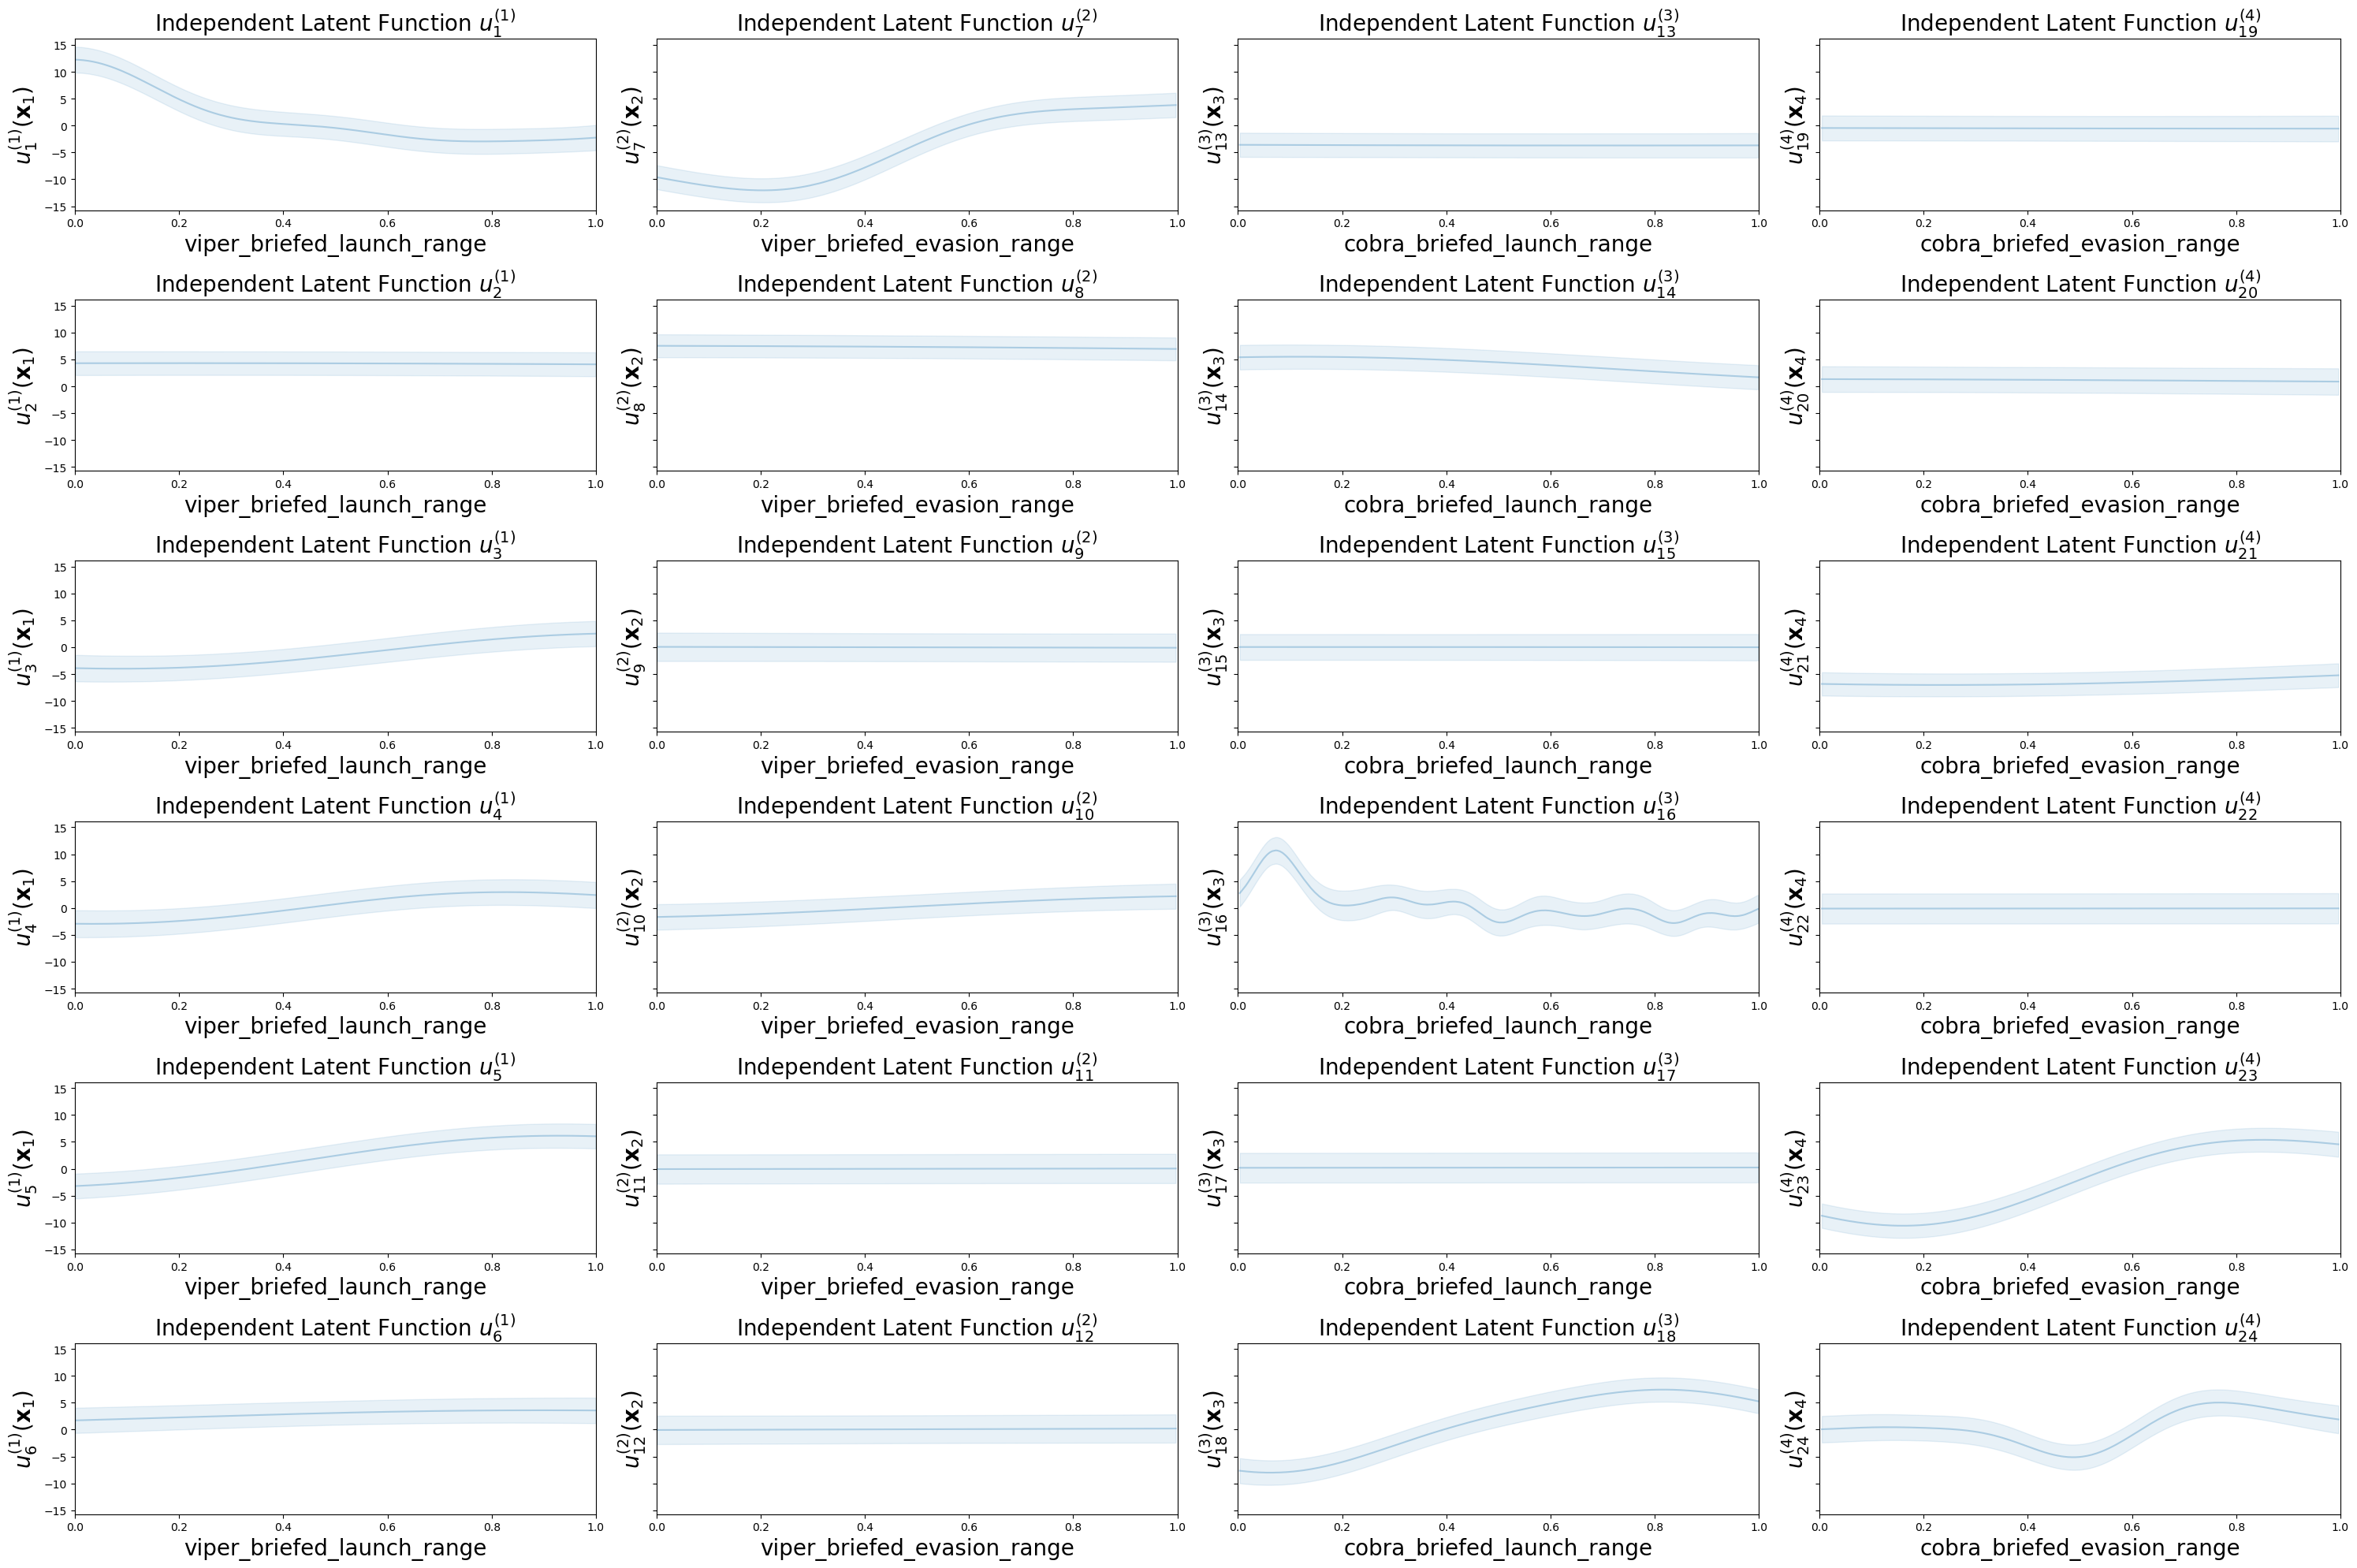

In [92]:
# visualize the result
input_dim = train_x.size(-1)
num_latents = ilf_mean.size(0)
n_categories = 4

# visualize the result
fig, func = plt.subplots(nrows=num_latents // input_dim, ncols=input_dim, figsize=(30, 20), sharey=True)
# x="x"

for j in range(input_dim):
    row = 0
    for i in range(num_latents):
        # print(i, j)
        if j == active_dims[i][0]:
            indices = np.argsort(train_x[:,j])
            line, = func[row,j].plot(train_x[indices,j], ilf_mean[i,indices], alpha=0.3)
            func[row,j].fill_between(
                train_x[indices,j], ilf_lower[i,indices],
                ilf_upper[i,indices], alpha=0.1, color=line.get_color()
            )
            # func[row,j].set_xlabel(f"${{\mathbf{{x}}_{{{j+1}}}}}$", fontdict={'fontsize':20})
            func[row,j].set_xlabel(inputs[j], fontdict={'fontsize':20})
            func[row,j].set_ylabel(f"${{u_{{{i+1}}}^{{({j+1})}}(\mathbf{{x}}_{{{j+1}}})}}$", fontdict={'fontsize':20})
            func[row,j].set_title(f"Independent Latent Function ${{u_{{{i+1}}}^{{({j+1})}}}}$", fontdict={'fontsize':20})
            func[row,j].set_xlim([0.,1.])
            row += 1

fig.tight_layout()

In [93]:
def compute_f_pd_p(
    x, 
    input_dim, 
    output_d, # which output dimension
    ilf, 
    lmc, 
    active_dims, 
    get_indices=True
):
    active_dims = np.array(active_dims)
    lpf_idx, _ = np.where(active_dims==[input_dim])
    indices = np.argsort(x[:,input_dim])
    f_pd = (ilf.T[:,lpf_idx] @ lmc[lpf_idx,:])[indices,output_d]
    if get_indices:
        return indices, f_pd
    else:
        return f_pd

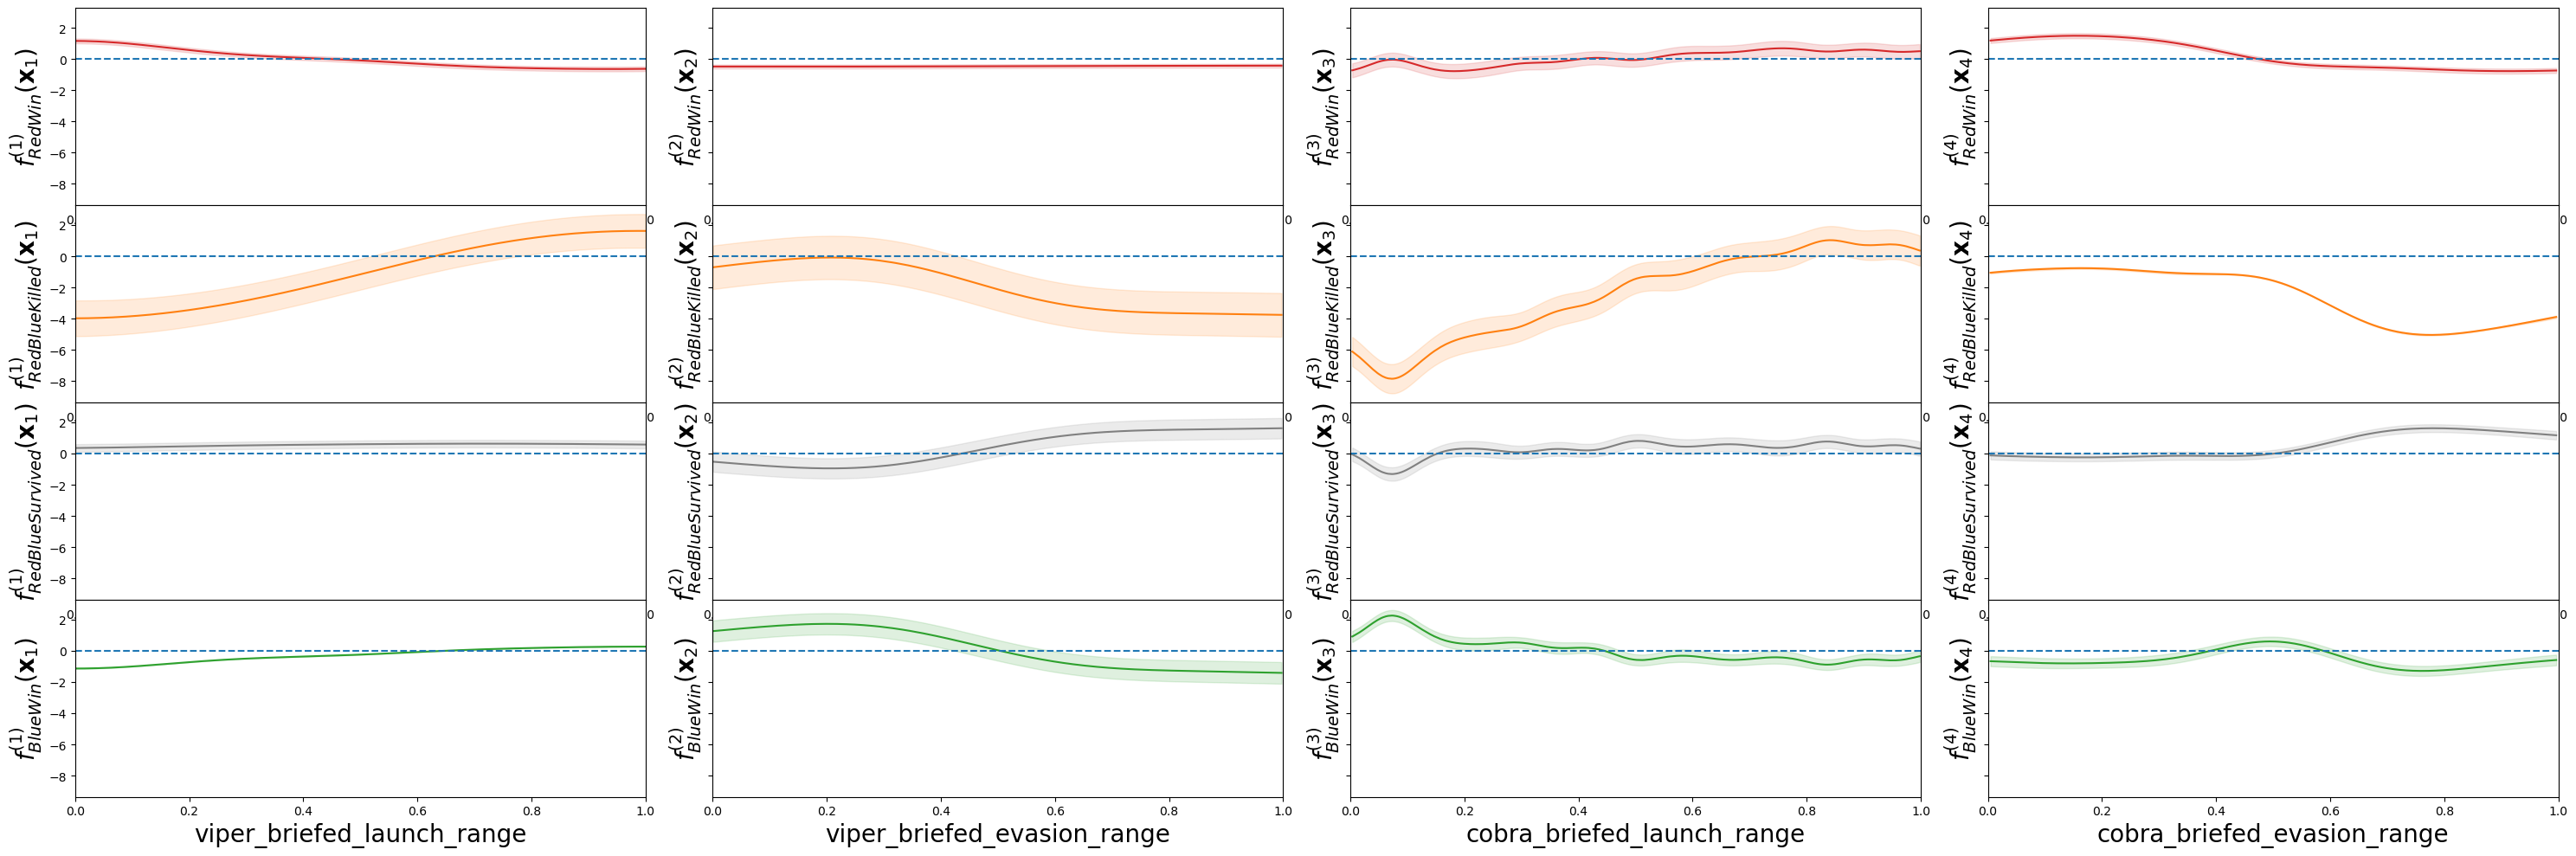

In [94]:
# visualize the result
categories = outcome_l[:4]
input_dim = train_x.size(-1)
n_categories = 4

# visualize the result
fig, func = plt.subplots(nrows=n_categories, ncols=input_dim, figsize=(30, 10), sharey=True)
c = ["tab:red", "tab:orange", "tab:gray", "tab:green"]
# c = ["tab:red", "tab:gray", "tab:green"]

for j in range(input_dim):
    row = 0
    for i in range(n_categories):
        # print(f"plot ({inputs[j]}, {categories[row]}) in row={row}, col={j}")
        indices = np.argsort(train_x[:,j]) 
        indices, f_mean = compute_f_pd_p(train_x, j, row, ilf_mean, lmc_coefficients, active_dims)
        _, f_lower = compute_f_pd_p(train_x, j, row, ilf_lower, lmc_coefficients, active_dims)
        _, f_upper = compute_f_pd_p(train_x, j, row, ilf_upper, lmc_coefficients, active_dims)
        line, = func[row,j].plot(train_x[indices,j], f_mean, alpha=0.99, c=c[row])
        func[row,j].fill_between(
            train_x[indices,j], f_lower,
            f_upper, alpha=0.15, color=line.get_color()
        )
        func[row,j].set_xlabel(inputs[j], fontdict={'fontsize':20})
        func[row,j].set_ylabel(f"${{f_{{{categories[row]}}}^{{({j+1})}}(\mathbf{{x}}_{{{j+1}}})}}$", fontdict={'fontsize':20})
        func[row,j].set_xlim([0.,1.])
        func[row,j].hlines(0, 0, 1, ls="--")
        row += 1

fig.tight_layout()
fig.subplots_adjust(hspace=0)

In [95]:
c_map = {
    # "cobra_launched": "red",
    # "cobra_launch_range": "maroon",
    "cobra_briefed_launch_range": "maroon",
    "cobra_briefed_evasion_range": "indianred",
    # "viper_launched": "blue",
    # "viper_launch_range": "navy",
    "viper_briefed_launch_range": "navy",
    "viper_briefed_evasion_range": "royalblue",
    "launch_range_diff": "darkgoldenrod",
    "evasion_range_diff": "black",
}

ls_map = {
    # "viper_launched": ":",
    # 'viper_launch_range': "-",
    'viper_briefed_launch_range': "-",
    'viper_briefed_evasion_range': "-.",
    # "cobra_launched": ":",
    # 'cobra_launch_range': "-",
    'cobra_briefed_launch_range': "-",
    'cobra_briefed_evasion_range': "-.",
    "launch_range_diff": ":",
    "evasion_range_diff": ":",
}

alpha_map = {
    "viper_launched": .9,
    # 'viper_launch_range': .9,
    'viper_briefed_launch_range': .9,
    'viper_briefed_evasion_range': .9,
    "cobra_launched": .9,
    # 'cobra_launch_range': .9,
    'cobra_briefed_launch_range': .9,
    'cobra_briefed_evasion_range': .9,
    "launch_range_diff": .9,
    "evasion_range_diff": .9,
}

Text(0.0, -13.5, 'scotts_pi score: 0.4325')

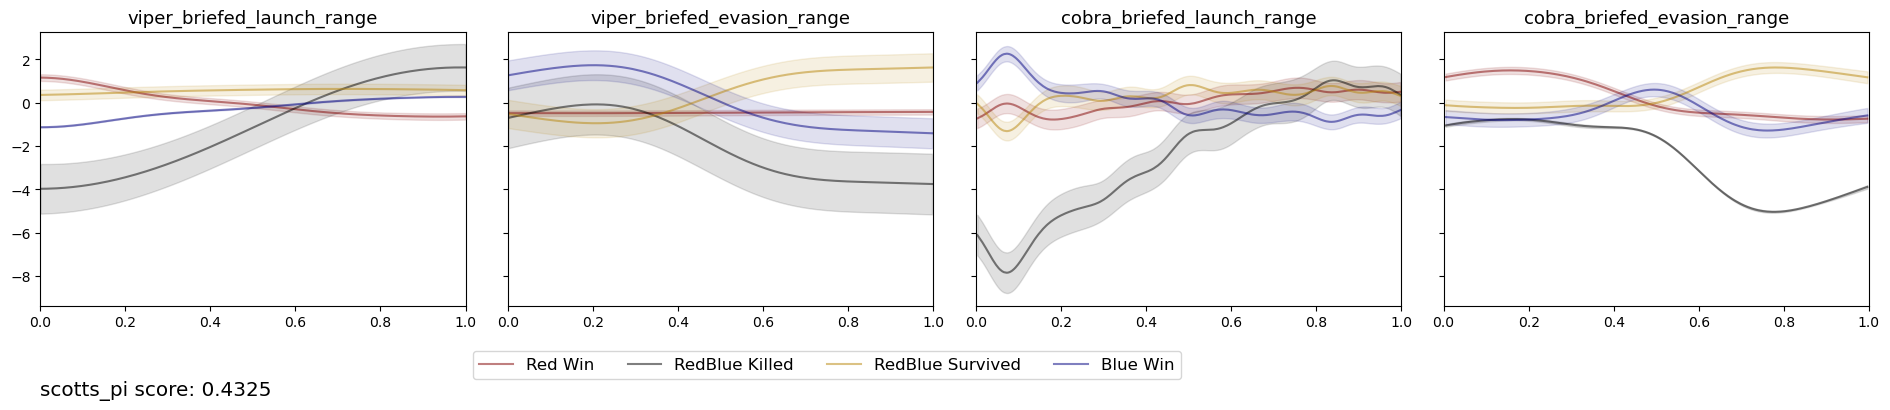

In [96]:
# visualize the result
input_dim = train_x.size(-1)
num_latents = ilf_mean.size(0)

# visualize the result
fig, func = plt.subplots(ncols=input_dim, figsize=(19, 3.5), sharey=True)
# x="x"

c = ["maroon", "black", "darkgoldenrod", "navy"]

ilf_idx = 0
for j in range(input_dim):
    for i in range(n_categories):
        c_ = c[i]
        ls = ls_map[inputs[j]]
        indices = np.argsort(train_x[:,j])
        indices, f_mean = compute_f_pd_p(train_x, j, i, ilf_mean, lmc_coefficients, active_dims)
        _, f_lower = compute_f_pd_p(train_x, j, i, ilf_lower, lmc_coefficients, active_dims)
        _, f_upper = compute_f_pd_p(train_x, j, i, ilf_upper, lmc_coefficients, active_dims)
        line, = func[j].plot(train_x[indices,j], f_mean, alpha=0.5, label=categories[i], c=c_)
        func[j].fill_between(
            train_x[indices,j], f_lower,
            f_upper, alpha=0.12, color=line.get_color()
        )
        # func[j].set_xlabel(f"${{\mathbf{{x}}_{{{j+1}}}}}$", fontdict={'fontsize':20})
        # func[j].set_xlabel(inputs[j], fontdict={'fontsize':10})
        # func[j].set_ylabel(f"${{f_{{{outcome_l[i]}}}^{{({j+1})}}(\mathbf{{x}}_{{{j+1}}})}}$", fontdict={'fontsize':20})
        func[j].set_title(inputs[j], fontdict={'fontsize':13})
        func[j].set_xlim([0.,1.])
        # func[j].hlines(0, 0, 1, ls="--")

fig.tight_layout()
fig.subplots_adjust(wspace=0.1)
func[1].legend(bbox_to_anchor=(.75, -.3), loc="lower center",  ncol = len(func[1].lines),
               prop={'size': 12})

score = scotts_pi(cm_test, weight_type="unweighted")
func[0].annotate(f"scotts_pi score: {score}", (0.0, -13.5), fontsize="x-large", annotation_clip=False)

In [97]:
n_categories

4

In [98]:
categories

['Red Win', 'RedBlue Killed', 'RedBlue Survived', 'Blue Win']

Text(0.0, -14.2, 'scotts_pi score: 0.4325')

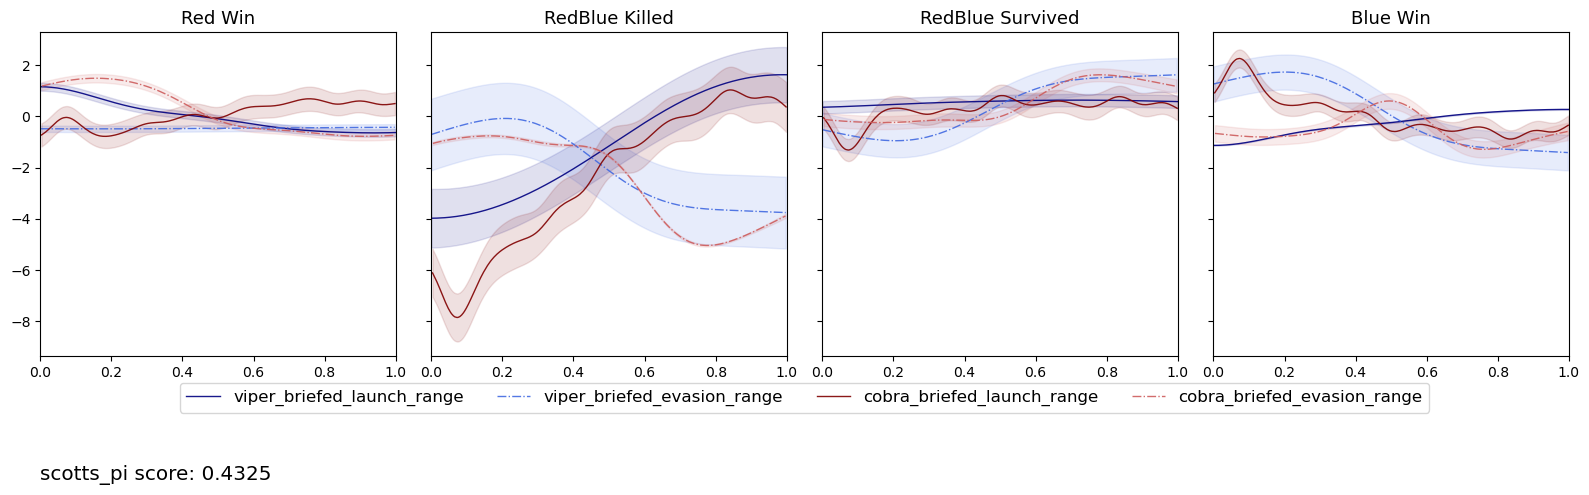

In [99]:
# visualize the result
input_dim = train_x.size(-1)
num_latents = ilf_mean.size(0)
n_categories = 4

# visualize the result
fig, func = plt.subplots(nrows=1, ncols=n_categories, figsize=(16, 4), sharey=True)

for j in range(input_dim):
    row = 0
    for i in range(n_categories):
        c = c_map[inputs[j]]
        ls = ls_map[inputs[j]]
        alpha = alpha_map[inputs[j]]
        indices = np.argsort(train_x[:,j])
        indices, f_mean = compute_f_pd_p(train_x, j, row, ilf_mean, lmc_coefficients, active_dims)
        _, f_lower = compute_f_pd_p(train_x, j, row, ilf_lower, lmc_coefficients, active_dims)
        _, f_upper = compute_f_pd_p(train_x, j, row, ilf_upper, lmc_coefficients, active_dims)
        line, = func[row].plot(train_x[indices,j], f_mean, alpha=alpha, lw=1, label=inputs[j], c=c, ls=ls)
        func[row].fill_between(
            train_x[indices,j], f_lower,
            f_upper, alpha=0.12, color=line.get_color()
        )
        # func[row].set_xlabel(f"${{\mathbf{{x}}_{{{j+1}}}}}$", fontdict={'fontsize':20})
        # func[row].set_ylabel(f"${{f_{{{outcome_l[row]}}}^{{({j+1})}}(\mathbf{{x}}_{{{j+1}}})}}$", fontdict={'fontsize':20})
        func[row].set_title(categories[row], fontdict={'fontsize':13})
        # func[row].hlines(0, 0, 1, ls="-", color="k", lw=.5)
        func[row].set_xlim([0.,1.])
        # func[row].legend()
        row += 1

fig.tight_layout()
fig.subplots_adjust(wspace=0.1)
func[1].legend(bbox_to_anchor=(1.05, -.2), loc="lower center",  ncol = len(func[1].lines),
               prop={'size': 12})

score = scotts_pi(cm_test, weight_type="unweighted")
func[0].annotate(f"scotts_pi score: {score}", (0.0, -14.2), fontsize="x-large", annotation_clip=False)

Text(0.0, -14.2, 'scotts_pi score: 0.4325')

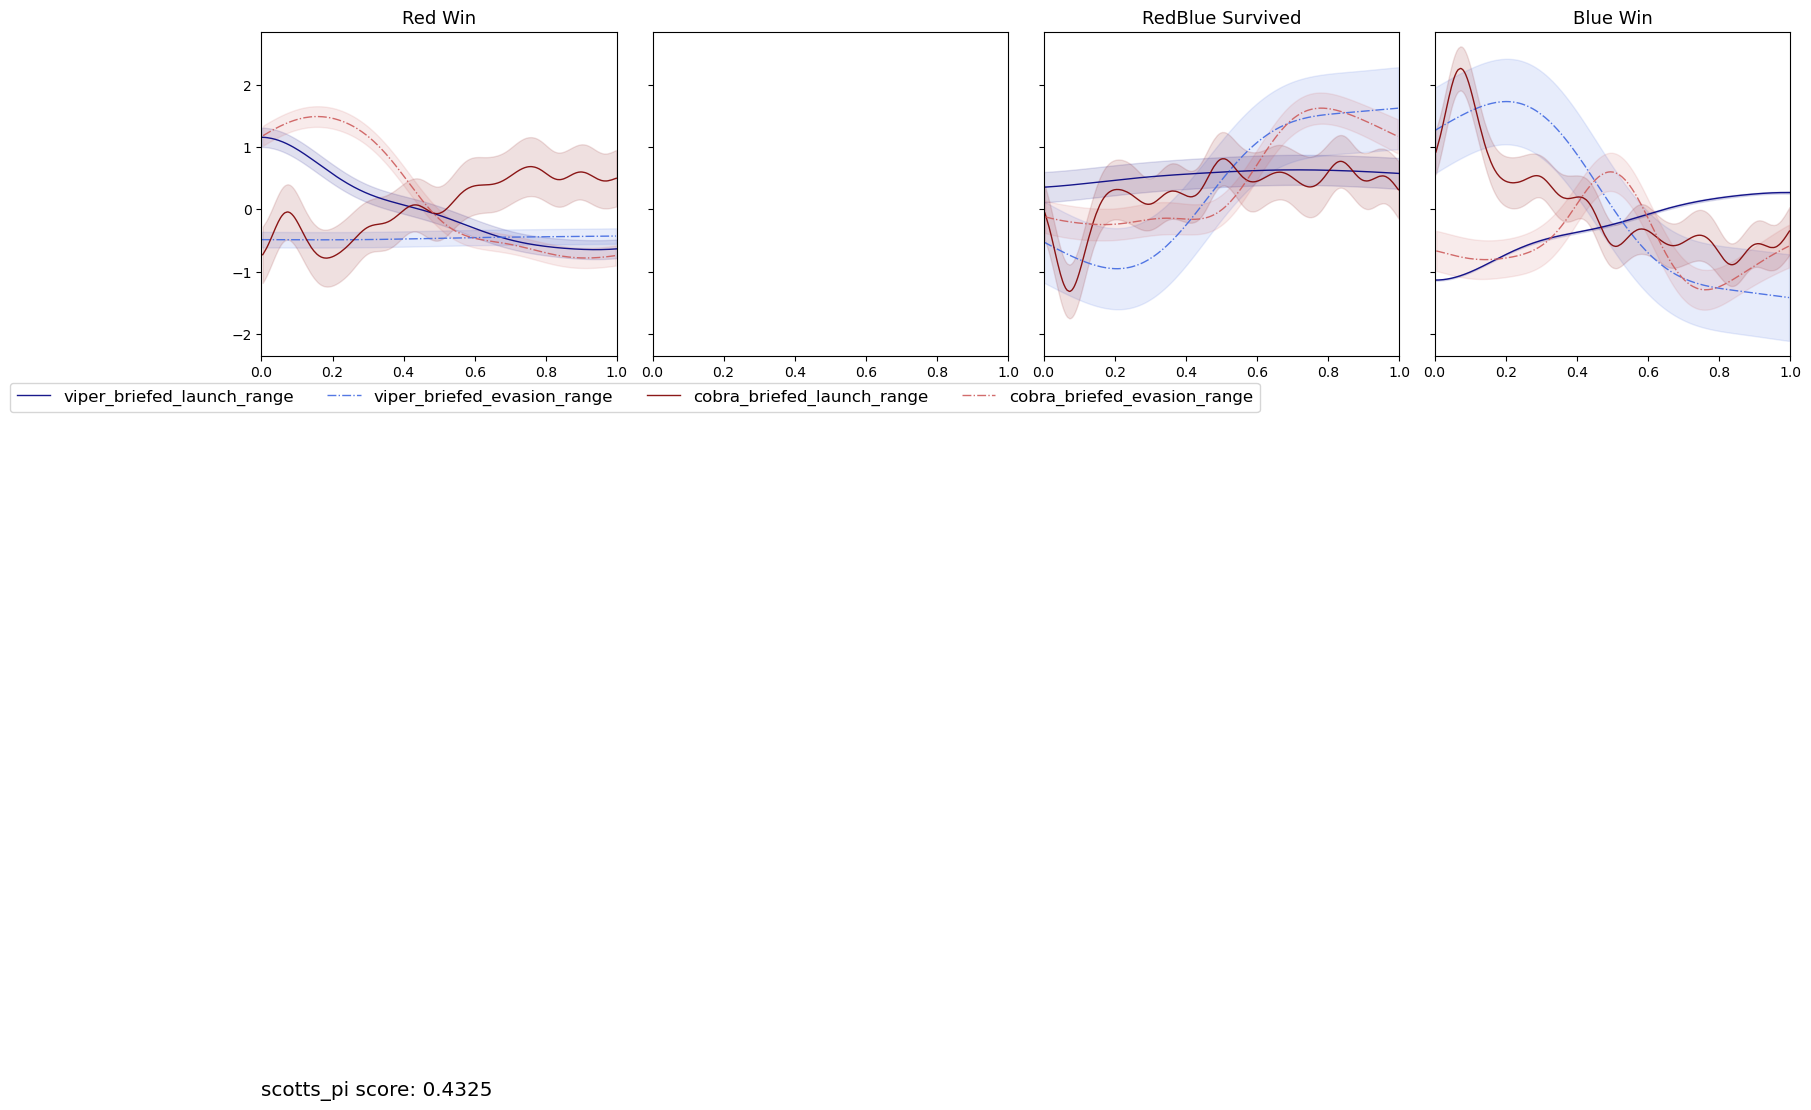

In [100]:
# visualize the result
input_dim = train_x.size(-1)
num_latents = ilf_mean.size(0)
n_categories = 4

# visualize the result
fig, func = plt.subplots(nrows=1, ncols=n_categories, figsize=(16, 4), sharey=True)

for j in range(input_dim):
    row = 0
    for i in range(n_categories):
        if row != 1:
            c = c_map[inputs[j]]
            ls = ls_map[inputs[j]]
            alpha = alpha_map[inputs[j]]
            indices = np.argsort(train_x[:,j])
            indices, f_mean = compute_f_pd_p(train_x, j, row, ilf_mean, lmc_coefficients, active_dims)
            _, f_lower = compute_f_pd_p(train_x, j, row, ilf_lower, lmc_coefficients, active_dims)
            _, f_upper = compute_f_pd_p(train_x, j, row, ilf_upper, lmc_coefficients, active_dims)
            line, = func[row].plot(train_x[indices,j], f_mean, alpha=alpha, lw=1, label=inputs[j], c=c, ls=ls)
            func[row].fill_between(
                train_x[indices,j], f_lower,
                f_upper, alpha=0.12, color=line.get_color()
            )
            # func[row].set_xlabel(f"${{\mathbf{{x}}_{{{j+1}}}}}$", fontdict={'fontsize':20})
            # func[row].set_ylabel(f"${{f_{{{outcome_l[row]}}}^{{({j+1})}}(\mathbf{{x}}_{{{j+1}}})}}$", fontdict={'fontsize':20})
            func[row].set_title(categories[row], fontdict={'fontsize':13})
            # func[row].hlines(0, 0, 1, ls="-", color="k", lw=.5)
            func[row].set_xlim([0.,1.])
            # func[row].legend()
        row += 1

fig.tight_layout()
fig.subplots_adjust(wspace=0.1)
func[0].legend(bbox_to_anchor=(1.05, -.2), loc="lower center",  ncol = len(func[0].lines),
               prop={'size': 12})

score = scotts_pi(cm_test, weight_type="unweighted")
func[0].annotate(f"scotts_pi score: {score}", (0.0, -14.2), fontsize="x-large", annotation_clip=False)

#### computation and plots for parsimonious model

In [127]:
lmc_df.iloc[0,-1].size

192

In [360]:
# Sturge's formula for calculating n_bins
# n_bins = int(np.ceil(np.log2(lmc_coeffs["21"].size(0))) + 1)

lmc_concat = np.concatenate([np.abs(lmc_df.iloc[-1,-1]), np.abs(lmc_df.iloc[-2,-1])])
# bin_width = round(lmc_concat.max() / n_bins,2)
# bins = np.arange(0, lmc_concat.max()+.2, step=bin_width)
bins = np.linspace(0, lmc_concat.max()+.1, lmc_df.iloc[-1,-1].size)
count_01, _ = np.histogram(np.abs(lmc_df.iloc[-2,-1]), 
                           bins=bins)
count_21, _ = np.histogram(np.abs(lmc_df.iloc[-1,-1]), 
                           bins=bins)

<AxesSubplot: ylabel='Count'>

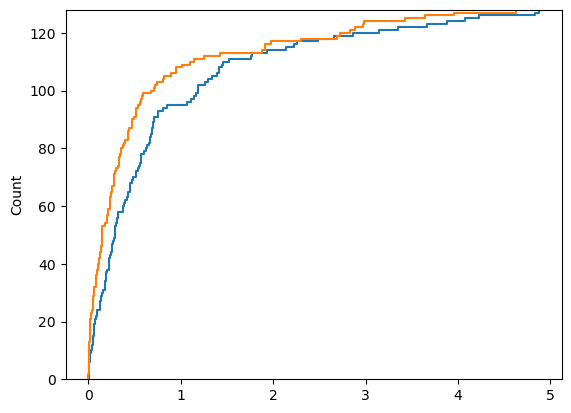

In [361]:
sns.ecdfplot(np.abs(lmc_df.iloc[-2,-1]), stat="count")
sns.ecdfplot(np.abs(lmc_df.iloc[-1,-1]), stat="count")

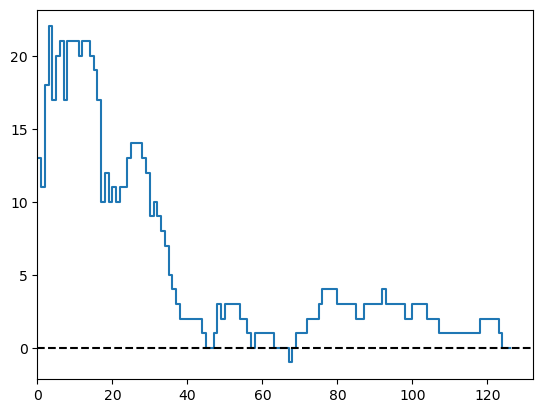

In [362]:
fig, ax = plt.subplots()

ax.step(x=np.arange(len(count_21)), y=count_21.cumsum() - count_01.cumsum(), where="post")
ax.set_xlim(0)
_, xmax = ax.get_xlim()
ax.hlines(0, 0, xmax, ls="--", colors="black")
# ax.set_xticks(np.arange(0, len(bins)))
# ax.set_xticklabels(bins)
# ax.set_xticks([0,1,2],rotate=90)

Explain reason for omitting signal variance for model

<AxesSubplot: ylabel='Density'>

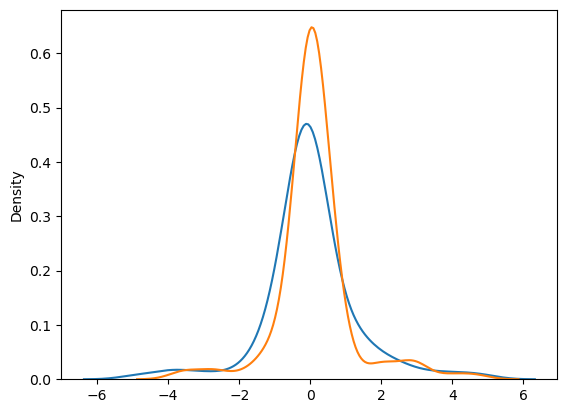

In [363]:
sns.kdeplot(lmc_df.iloc[-2,-1])
sns.kdeplot(lmc_df.iloc[-1,-1])

In [103]:
def scotts_pi(confusion_matrix, weight_type = "unweighted", return_weights=False):

    cm = confusion_matrix
    w = np.zeros_like(cm, dtype=np.float64)
    row, col = cm.shape
    cat = np.arange(1,row+1) # Category starts from 1,2,...K
    
    # Compute the weights
    for i in range(row):
        # j = i
        for j in range(col):
            if i == j:
                w_res = 1
            else:
                if weight_type == "quadratic":
                        w_res = 1 - (cat[i] - cat[j])**2 / (cat.max() - 1)**2
                elif weight_type == "linear":
                    w_res = 1 - np.abs(cat[i] - cat[j]) / (cat.max() - 1)
                elif weight_type == "ordinal":
                    m_ij = max(cat[i], cat[j]) - min(cat[i], cat[j]) + 1
                    m_max = cat.max() - cat.min() + 1
                    w_res = 1 - (m_ij / m_max)
                elif weight_type == "radical":
                    w_res = 1 - (np.sqrt(np.abs(cat[i] - cat[j])) / np.sqrt(np.abs(cat.max() - 1)))
                elif weight_type == "unweighted":
                    w_res = 0
                elif weight_type == "bipolar":
                    m_max = 0
                    for ii in range(row):
                        for jj in range(col):
                            if ii != jj:
                                m_tmp = (cat[ii] - cat[jj])**2 / ((cat[ii] + cat[jj] - 2) * (2 * cat.max() - cat[ii] - cat[jj]))
                                if m_max < m_tmp:
                                    m_max = m_tmp
                    w_res = 1 - (cat[i] - cat[j])**2 / (m_max * (cat[i] + cat[j] - 2) * (2 * cat.max() - cat[i] - cat[j]))
            w[i,j] = w_res
            w[j,i] = w_res
    
    total = cm.sum()
    row_marginal = cm.sum(-1) / total
    col_marginal = cm.sum(0) / total
    freq = cm / total
    P_0 = (w * freq).sum()
    # P_0 = np.diagonal(cm).sum() / cm.sum()
    
    # Compute P_e 
    P_e = 0.0
    for i in range(row):
        # for j in range(col):
        j = i
        p_i = (row_marginal[i] + col_marginal[i]) / 2
        p_j = (row_marginal[j] + col_marginal[j]) / 2
        P_e += w[i,j] * p_i * p_j

    A = np.round((P_0 - P_e) / (1 - P_e), 4)
    
    if return_weights:
        return w, P_0, P_e, A
    else:
        return A

In [113]:
cm = np.eye(10)
# cm = np.arange(1,10).reshape(3,3)

In [114]:
scotts_pi(cm, weight_type="unweighted", return_weights=True)

(array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]),
 1.0,
 0.10000000000000003,
 1.0)

In [115]:
scotts_pi(cm, weight_type="bipolar", return_weights=True)

(array([[1.        , 0.94117647, 0.875     , 0.8       , 0.71428571,
         0.61538462, 0.5       , 0.36363636, 0.2       , 0.        ],
        [0.94117647, 1.        , 0.97777778, 0.92857143, 0.86153846,
         0.77777778, 0.67532468, 0.55      , 0.39506173, 0.2       ],
        [0.875     , 0.97777778, 1.        , 0.98461538, 0.94444444,
         0.88311688, 0.8       , 0.69135802, 0.55      , 0.36363636],
        [0.8       , 0.92857143, 0.98461538, 1.        , 0.98701299,
         0.95      , 0.88888889, 0.8       , 0.67532468, 0.5       ],
        [0.71428571, 0.86153846, 0.94444444, 0.98701299, 1.        ,
         0.98765432, 0.95      , 0.88311688, 0.77777778, 0.61538462],
        [0.61538462, 0.77777778, 0.88311688, 0.95      , 0.98765432,
         1.        , 0.98701299, 0.94444444, 0.86153846, 0.71428571],
        [0.5       , 0.67532468, 0.8       , 0.88888889, 0.95      ,
         0.98701299, 1.        , 0.98461538, 0.92857143, 0.8       ],
        [0.36363636, 0.55  

In [116]:
scotts_pi(cm, weight_type="linear", return_weights=True)

(array([[1.        , 0.88888889, 0.77777778, 0.66666667, 0.55555556,
         0.44444444, 0.33333333, 0.22222222, 0.11111111, 0.        ],
        [0.88888889, 1.        , 0.88888889, 0.77777778, 0.66666667,
         0.55555556, 0.44444444, 0.33333333, 0.22222222, 0.11111111],
        [0.77777778, 0.88888889, 1.        , 0.88888889, 0.77777778,
         0.66666667, 0.55555556, 0.44444444, 0.33333333, 0.22222222],
        [0.66666667, 0.77777778, 0.88888889, 1.        , 0.88888889,
         0.77777778, 0.66666667, 0.55555556, 0.44444444, 0.33333333],
        [0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ,
         0.88888889, 0.77777778, 0.66666667, 0.55555556, 0.44444444],
        [0.44444444, 0.55555556, 0.66666667, 0.77777778, 0.88888889,
         1.        , 0.88888889, 0.77777778, 0.66666667, 0.55555556],
        [0.33333333, 0.44444444, 0.55555556, 0.66666667, 0.77777778,
         0.88888889, 1.        , 0.88888889, 0.77777778, 0.66666667],
        [0.22222222, 0.3333

In [117]:
scotts_pi(cm, weight_type="quadratic", return_weights=True)

(array([[1.        , 0.98765432, 0.95061728, 0.88888889, 0.80246914,
         0.69135802, 0.55555556, 0.39506173, 0.20987654, 0.        ],
        [0.98765432, 1.        , 0.98765432, 0.95061728, 0.88888889,
         0.80246914, 0.69135802, 0.55555556, 0.39506173, 0.20987654],
        [0.95061728, 0.98765432, 1.        , 0.98765432, 0.95061728,
         0.88888889, 0.80246914, 0.69135802, 0.55555556, 0.39506173],
        [0.88888889, 0.95061728, 0.98765432, 1.        , 0.98765432,
         0.95061728, 0.88888889, 0.80246914, 0.69135802, 0.55555556],
        [0.80246914, 0.88888889, 0.95061728, 0.98765432, 1.        ,
         0.98765432, 0.95061728, 0.88888889, 0.80246914, 0.69135802],
        [0.69135802, 0.80246914, 0.88888889, 0.95061728, 0.98765432,
         1.        , 0.98765432, 0.95061728, 0.88888889, 0.80246914],
        [0.55555556, 0.69135802, 0.80246914, 0.88888889, 0.95061728,
         0.98765432, 1.        , 0.98765432, 0.95061728, 0.88888889],
        [0.39506173, 0.5555

In [118]:
scotts_pi(cm, weight_type="radical", return_weights=True)

(array([[1.        , 0.66666667, 0.52859548, 0.42264973, 0.33333333,
         0.25464401, 0.18350342, 0.1180829 , 0.05719096, 0.        ],
        [0.66666667, 1.        , 0.66666667, 0.52859548, 0.42264973,
         0.33333333, 0.25464401, 0.18350342, 0.1180829 , 0.05719096],
        [0.52859548, 0.66666667, 1.        , 0.66666667, 0.52859548,
         0.42264973, 0.33333333, 0.25464401, 0.18350342, 0.1180829 ],
        [0.42264973, 0.52859548, 0.66666667, 1.        , 0.66666667,
         0.52859548, 0.42264973, 0.33333333, 0.25464401, 0.18350342],
        [0.33333333, 0.42264973, 0.52859548, 0.66666667, 1.        ,
         0.66666667, 0.52859548, 0.42264973, 0.33333333, 0.25464401],
        [0.25464401, 0.33333333, 0.42264973, 0.52859548, 0.66666667,
         1.        , 0.66666667, 0.52859548, 0.42264973, 0.33333333],
        [0.18350342, 0.25464401, 0.33333333, 0.42264973, 0.52859548,
         0.66666667, 1.        , 0.66666667, 0.52859548, 0.42264973],
        [0.1180829 , 0.1835

In [119]:
cm.sum(0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

(array([[1.  , 0.75, 0.  ],
        [0.75, 1.  , 0.75],
        [0.  , 0.75, 1.  ]]),
 -0.0563,
 0.3333333333333333)

In [26]:
np.diagonal(cm).sum() / cm.sum()

0.3333333333333333

In [21]:
np.eye(3) * cm

array([[1., 0., 0.],
       [0., 5., 0.],
       [0., 0., 9.]])

In [16]:
np.diag(w)

array([1., 1., 1.])